# Miller age

In [1]:
ood_seed = 5

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Bud tip progenitor', '18.0'), 683)


Removed datapoint: 683

train         5395
validation    1327
ood            683
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 101279.98it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1017221.40it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 220.35it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<20:08,  3.03s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<20:08,  3.03s/it, v_num=1, recon=1.25e+3, r2_mean=0.059, adv_loss=3.48, acc_pert=0.292, acc_integration_donor=0.141]

Epoch 2/400:   0%|          | 1/400 [00:03<20:08,  3.03s/it, v_num=1, recon=1.25e+3, r2_mean=0.059, adv_loss=3.48, acc_pert=0.292, acc_integration_donor=0.141]

Epoch 2/400:   0%|          | 2/400 [00:06<20:26,  3.08s/it, v_num=1, recon=1.25e+3, r2_mean=0.059, adv_loss=3.48, acc_pert=0.292, acc_integration_donor=0.141]

Epoch 2/400:   0%|          | 2/400 [00:06<20:26,  3.08s/it, v_num=1, recon=1.06e+3, r2_mean=0.288, adv_loss=3.05, acc_pert=0.454, acc_integration_donor=0.254]

Epoch 3/400:   0%|          | 2/400 [00:06<20:26,  3.08s/it, v_num=1, recon=1.06e+3, r2_mean=0.288, adv_loss=3.05, acc_pert=0.454, acc_integration_donor=0.254]

Epoch 3/400:   1%|          | 3/400 [00:08<18:17,  2.77s/it, v_num=1, recon=1.06e+3, r2_mean=0.288, adv_loss=3.05, acc_pert=0.454, acc_integration_donor=0.254]

Epoch 3/400:   1%|          | 3/400 [00:08<18:17,  2.77s/it, v_num=1, recon=972, r2_mean=0.383, adv_loss=2.7, acc_pert=0.489, acc_integration_donor=0.417]     

Epoch 4/400:   1%|          | 3/400 [00:08<18:17,  2.77s/it, v_num=1, recon=972, r2_mean=0.383, adv_loss=2.7, acc_pert=0.489, acc_integration_donor=0.417]

Epoch 4/400:   1%|          | 4/400 [00:10<17:15,  2.61s/it, v_num=1, recon=972, r2_mean=0.383, adv_loss=2.7, acc_pert=0.489, acc_integration_donor=0.417]

Epoch 4/400:   1%|          | 4/400 [00:10<17:15,  2.61s/it, v_num=1, recon=940, r2_mean=0.434, adv_loss=2.5, acc_pert=0.504, acc_integration_donor=0.478]

Epoch 5/400:   1%|          | 4/400 [00:10<17:15,  2.61s/it, v_num=1, recon=940, r2_mean=0.434, adv_loss=2.5, acc_pert=0.504, acc_integration_donor=0.478]

Epoch 5/400:   1%|▏         | 5/400 [00:13<16:39,  2.53s/it, v_num=1, recon=940, r2_mean=0.434, adv_loss=2.5, acc_pert=0.504, acc_integration_donor=0.478]

Epoch 5/400:   1%|▏         | 5/400 [00:13<16:39,  2.53s/it, v_num=1, recon=918, r2_mean=0.448, adv_loss=2.36, acc_pert=0.514, acc_integration_donor=0.5] 

Epoch 6/400:   1%|▏         | 5/400 [00:13<16:39,  2.53s/it, v_num=1, recon=918, r2_mean=0.448, adv_loss=2.36, acc_pert=0.514, acc_integration_donor=0.5]

Epoch 6/400:   2%|▏         | 6/400 [00:15<16:16,  2.48s/it, v_num=1, recon=918, r2_mean=0.448, adv_loss=2.36, acc_pert=0.514, acc_integration_donor=0.5]

Epoch 6/400:   2%|▏         | 6/400 [00:15<16:16,  2.48s/it, v_num=1, recon=906, r2_mean=0.464, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.505]

Epoch 7/400:   2%|▏         | 6/400 [00:15<16:16,  2.48s/it, v_num=1, recon=906, r2_mean=0.464, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.505]

Epoch 7/400:   2%|▏         | 7/400 [00:18<16:02,  2.45s/it, v_num=1, recon=906, r2_mean=0.464, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.505]

Epoch 7/400:   2%|▏         | 7/400 [00:18<16:02,  2.45s/it, v_num=1, recon=900, r2_mean=0.477, adv_loss=2.23, acc_pert=0.544, acc_integration_donor=0.523]

Epoch 8/400:   2%|▏         | 7/400 [00:18<16:02,  2.45s/it, v_num=1, recon=900, r2_mean=0.477, adv_loss=2.23, acc_pert=0.544, acc_integration_donor=0.523]

Epoch 8/400:   2%|▏         | 8/400 [00:20<15:59,  2.45s/it, v_num=1, recon=900, r2_mean=0.477, adv_loss=2.23, acc_pert=0.544, acc_integration_donor=0.523]

Epoch 8/400:   2%|▏         | 8/400 [00:20<15:59,  2.45s/it, v_num=1, recon=890, r2_mean=0.478, adv_loss=2.18, acc_pert=0.567, acc_integration_donor=0.524]

Epoch 9/400:   2%|▏         | 8/400 [00:20<15:59,  2.45s/it, v_num=1, recon=890, r2_mean=0.478, adv_loss=2.18, acc_pert=0.567, acc_integration_donor=0.524]

Epoch 9/400:   2%|▏         | 9/400 [00:22<15:49,  2.43s/it, v_num=1, recon=890, r2_mean=0.478, adv_loss=2.18, acc_pert=0.567, acc_integration_donor=0.524]

Epoch 9/400:   2%|▏         | 9/400 [00:22<15:49,  2.43s/it, v_num=1, recon=889, r2_mean=0.491, adv_loss=2.19, acc_pert=0.568, acc_integration_donor=0.507]

Epoch 10/400:   2%|▏         | 9/400 [00:22<15:49,  2.43s/it, v_num=1, recon=889, r2_mean=0.491, adv_loss=2.19, acc_pert=0.568, acc_integration_donor=0.507]


disnt_basal = 0.5381695077211255

disnt_after = 0.9320271988139694

val_r2_mean = 0.5048847624233791

val_r2_var = 0.19714461663713703


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:35<36:52,  5.67s/it, v_num=1, recon=889, r2_mean=0.491, adv_loss=2.19, acc_pert=0.568, acc_integration_donor=0.507]

Epoch 10/400:   2%|▎         | 10/400 [00:35<36:52,  5.67s/it, v_num=1, recon=878, r2_mean=0.493, adv_loss=2.17, acc_pert=0.563, acc_integration_donor=0.506, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:35<36:52,  5.67s/it, v_num=1, recon=878, r2_mean=0.493, adv_loss=2.17, acc_pert=0.563, acc_integration_donor=0.506, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:38<30:54,  4.77s/it, v_num=1, recon=878, r2_mean=0.493, adv_loss=2.17, acc_pert=0.563, acc_integration_donor=0.506, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:38<30:54,  4.77s/it, v_num=1, recon=881, r2_mean=0.502, adv_loss=2.18, acc_pert=0.561, acc_integration_donor=0.506, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:38<30:54,  4.77s/it, v_num=1, recon=881, r2_mean=0.502, adv_loss=2.18, acc_pert=0.561, acc_integration_donor=0.506, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:40<26:15,  4.06s/it, v_num=1, recon=881, r2_mean=0.502, adv_loss=2.18, acc_pert=0.561, acc_integration_donor=0.506, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:40<26:15,  4.06s/it, v_num=1, recon=870, r2_mean=0.506, adv_loss=2.16, acc_pert=0.547, acc_integration_donor=0.515, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:40<26:15,  4.06s/it, v_num=1, recon=870, r2_mean=0.506, adv_loss=2.16, acc_pert=0.547, acc_integration_donor=0.515, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:43<22:56,  3.56s/it, v_num=1, recon=870, r2_mean=0.506, adv_loss=2.16, acc_pert=0.547, acc_integration_donor=0.515, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:43<22:56,  3.56s/it, v_num=1, recon=868, r2_mean=0.504, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.499, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:43<22:56,  3.56s/it, v_num=1, recon=868, r2_mean=0.504, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.499, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:45<20:36,  3.20s/it, v_num=1, recon=868, r2_mean=0.504, adv_loss=2.17, acc_pert=0.541, acc_integration_donor=0.499, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:45<20:36,  3.20s/it, v_num=1, recon=871, r2_mean=0.515, adv_loss=2.17, acc_pert=0.547, acc_integration_donor=0.502, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:45<20:36,  3.20s/it, v_num=1, recon=871, r2_mean=0.515, adv_loss=2.17, acc_pert=0.547, acc_integration_donor=0.502, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:48<18:57,  2.95s/it, v_num=1, recon=871, r2_mean=0.515, adv_loss=2.17, acc_pert=0.547, acc_integration_donor=0.502, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:48<18:57,  2.95s/it, v_num=1, recon=863, r2_mean=0.511, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.496, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:48<18:57,  2.95s/it, v_num=1, recon=863, r2_mean=0.511, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.496, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:50<17:48,  2.78s/it, v_num=1, recon=863, r2_mean=0.511, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.496, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:50<17:48,  2.78s/it, v_num=1, recon=862, r2_mean=0.52, adv_loss=2.18, acc_pert=0.541, acc_integration_donor=0.504, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [00:50<17:48,  2.78s/it, v_num=1, recon=862, r2_mean=0.52, adv_loss=2.18, acc_pert=0.541, acc_integration_donor=0.504, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:52<16:53,  2.65s/it, v_num=1, recon=862, r2_mean=0.52, adv_loss=2.18, acc_pert=0.541, acc_integration_donor=0.504, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:52<16:53,  2.65s/it, v_num=1, recon=857, r2_mean=0.525, adv_loss=2.19, acc_pert=0.551, acc_integration_donor=0.501, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:52<16:53,  2.65s/it, v_num=1, recon=857, r2_mean=0.525, adv_loss=2.19, acc_pert=0.551, acc_integration_donor=0.501, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:55<16:22,  2.57s/it, v_num=1, recon=857, r2_mean=0.525, adv_loss=2.19, acc_pert=0.551, acc_integration_donor=0.501, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:55<16:22,  2.57s/it, v_num=1, recon=853, r2_mean=0.523, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.488, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [00:55<16:22,  2.57s/it, v_num=1, recon=853, r2_mean=0.523, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.488, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:57<15:57,  2.51s/it, v_num=1, recon=853, r2_mean=0.523, adv_loss=2.22, acc_pert=0.534, acc_integration_donor=0.488, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:57<15:57,  2.51s/it, v_num=1, recon=859, r2_mean=0.528, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.492, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:57<15:57,  2.51s/it, v_num=1, recon=859, r2_mean=0.528, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.492, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.5092542300359487

disnt_after = 0.8839054484788853

val_r2_mean = 0.4933741790327159

val_r2_var = 0.3069178319790147


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:07<30:46,  4.86s/it, v_num=1, recon=859, r2_mean=0.528, adv_loss=2.19, acc_pert=0.541, acc_integration_donor=0.492, val_recon=902, disnt_basal=0.538, disnt_after=0.932, val_r2_mean=0.505, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:07<30:46,  4.86s/it, v_num=1, recon=850, r2_mean=0.53, adv_loss=2.15, acc_pert=0.552, acc_integration_donor=0.501, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [01:07<30:46,  4.86s/it, v_num=1, recon=850, r2_mean=0.53, adv_loss=2.15, acc_pert=0.552, acc_integration_donor=0.501, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:10<25:58,  4.11s/it, v_num=1, recon=850, r2_mean=0.53, adv_loss=2.15, acc_pert=0.552, acc_integration_donor=0.501, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:10<25:58,  4.11s/it, v_num=1, recon=857, r2_mean=0.528, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.499, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:10<25:58,  4.11s/it, v_num=1, recon=857, r2_mean=0.528, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.499, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:12<22:32,  3.58s/it, v_num=1, recon=857, r2_mean=0.528, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.499, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:12<22:32,  3.58s/it, v_num=1, recon=850, r2_mean=0.52, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.493, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [01:12<22:32,  3.58s/it, v_num=1, recon=850, r2_mean=0.52, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.493, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:14<20:05,  3.20s/it, v_num=1, recon=850, r2_mean=0.52, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.493, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:14<20:05,  3.20s/it, v_num=1, recon=850, r2_mean=0.527, adv_loss=2.13, acc_pert=0.572, acc_integration_donor=0.506, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:14<20:05,  3.20s/it, v_num=1, recon=850, r2_mean=0.527, adv_loss=2.13, acc_pert=0.572, acc_integration_donor=0.506, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:17<18:27,  2.95s/it, v_num=1, recon=850, r2_mean=0.527, adv_loss=2.13, acc_pert=0.572, acc_integration_donor=0.506, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:17<18:27,  2.95s/it, v_num=1, recon=848, r2_mean=0.53, adv_loss=2.12, acc_pert=0.564, acc_integration_donor=0.512, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [01:17<18:27,  2.95s/it, v_num=1, recon=848, r2_mean=0.53, adv_loss=2.12, acc_pert=0.564, acc_integration_donor=0.512, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:19<17:22,  2.78s/it, v_num=1, recon=848, r2_mean=0.53, adv_loss=2.12, acc_pert=0.564, acc_integration_donor=0.512, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:19<17:22,  2.78s/it, v_num=1, recon=842, r2_mean=0.537, adv_loss=2.13, acc_pert=0.57, acc_integration_donor=0.512, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:19<17:22,  2.78s/it, v_num=1, recon=842, r2_mean=0.537, adv_loss=2.13, acc_pert=0.57, acc_integration_donor=0.512, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:22<16:31,  2.65s/it, v_num=1, recon=842, r2_mean=0.537, adv_loss=2.13, acc_pert=0.57, acc_integration_donor=0.512, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:22<16:31,  2.65s/it, v_num=1, recon=837, r2_mean=0.536, adv_loss=2.12, acc_pert=0.562, acc_integration_donor=0.509, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:22<16:31,  2.65s/it, v_num=1, recon=837, r2_mean=0.536, adv_loss=2.12, acc_pert=0.562, acc_integration_donor=0.509, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:24<16:01,  2.58s/it, v_num=1, recon=837, r2_mean=0.536, adv_loss=2.12, acc_pert=0.562, acc_integration_donor=0.509, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:24<16:01,  2.58s/it, v_num=1, recon=842, r2_mean=0.538, adv_loss=2.14, acc_pert=0.561, acc_integration_donor=0.514, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:24<16:01,  2.58s/it, v_num=1, recon=842, r2_mean=0.538, adv_loss=2.14, acc_pert=0.561, acc_integration_donor=0.514, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:27<16:56,  2.73s/it, v_num=1, recon=842, r2_mean=0.538, adv_loss=2.14, acc_pert=0.561, acc_integration_donor=0.514, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:27<16:56,  2.73s/it, v_num=1, recon=842, r2_mean=0.534, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.503, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [01:27<16:56,  2.73s/it, v_num=1, recon=842, r2_mean=0.534, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.503, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:29<16:16,  2.63s/it, v_num=1, recon=842, r2_mean=0.534, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.503, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:29<16:16,  2.63s/it, v_num=1, recon=840, r2_mean=0.538, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.507, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:29<16:16,  2.63s/it, v_num=1, recon=840, r2_mean=0.538, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.507, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]


disnt_basal = 0.49682780217216443

disnt_after = 0.9140893260896874

val_r2_mean = 0.5137148953296922

val_r2_var = 0.3545606580454033


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:44<37:56,  6.15s/it, v_num=1, recon=840, r2_mean=0.538, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.507, val_recon=869, disnt_basal=0.509, disnt_after=0.884, val_r2_mean=0.493, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:44<37:56,  6.15s/it, v_num=1, recon=841, r2_mean=0.543, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.504, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:44<37:56,  6.15s/it, v_num=1, recon=841, r2_mean=0.543, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.504, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:46<30:54,  5.03s/it, v_num=1, recon=841, r2_mean=0.543, adv_loss=2.19, acc_pert=0.539, acc_integration_donor=0.504, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:46<30:54,  5.03s/it, v_num=1, recon=834, r2_mean=0.547, adv_loss=2.16, acc_pert=0.555, acc_integration_donor=0.507, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:46<30:54,  5.03s/it, v_num=1, recon=834, r2_mean=0.547, adv_loss=2.16, acc_pert=0.555, acc_integration_donor=0.507, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:49<26:00,  4.24s/it, v_num=1, recon=834, r2_mean=0.547, adv_loss=2.16, acc_pert=0.555, acc_integration_donor=0.507, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:49<26:00,  4.24s/it, v_num=1, recon=836, r2_mean=0.544, adv_loss=2.18, acc_pert=0.539, acc_integration_donor=0.504, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [01:49<26:00,  4.24s/it, v_num=1, recon=836, r2_mean=0.544, adv_loss=2.18, acc_pert=0.539, acc_integration_donor=0.504, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:51<22:31,  3.68s/it, v_num=1, recon=836, r2_mean=0.544, adv_loss=2.18, acc_pert=0.539, acc_integration_donor=0.504, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:51<22:31,  3.68s/it, v_num=1, recon=831, r2_mean=0.55, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.513, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [01:51<22:31,  3.68s/it, v_num=1, recon=831, r2_mean=0.55, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.513, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:53<20:07,  3.30s/it, v_num=1, recon=831, r2_mean=0.55, adv_loss=2.19, acc_pert=0.535, acc_integration_donor=0.513, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:53<20:07,  3.30s/it, v_num=1, recon=828, r2_mean=0.544, adv_loss=2.21, acc_pert=0.535, acc_integration_donor=0.5, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan] 

Epoch 35/400:   8%|▊         | 34/400 [01:53<20:07,  3.30s/it, v_num=1, recon=828, r2_mean=0.544, adv_loss=2.21, acc_pert=0.535, acc_integration_donor=0.5, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:56<18:26,  3.03s/it, v_num=1, recon=828, r2_mean=0.544, adv_loss=2.21, acc_pert=0.535, acc_integration_donor=0.5, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:56<18:26,  3.03s/it, v_num=1, recon=834, r2_mean=0.547, adv_loss=2.22, acc_pert=0.532, acc_integration_donor=0.499, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [01:56<18:26,  3.03s/it, v_num=1, recon=834, r2_mean=0.547, adv_loss=2.22, acc_pert=0.532, acc_integration_donor=0.499, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:58<17:12,  2.84s/it, v_num=1, recon=834, r2_mean=0.547, adv_loss=2.22, acc_pert=0.532, acc_integration_donor=0.499, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [01:58<17:12,  2.84s/it, v_num=1, recon=830, r2_mean=0.549, adv_loss=2.24, acc_pert=0.527, acc_integration_donor=0.502, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [01:58<17:12,  2.84s/it, v_num=1, recon=830, r2_mean=0.549, adv_loss=2.24, acc_pert=0.527, acc_integration_donor=0.502, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:01<16:28,  2.72s/it, v_num=1, recon=830, r2_mean=0.549, adv_loss=2.24, acc_pert=0.527, acc_integration_donor=0.502, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:01<16:28,  2.72s/it, v_num=1, recon=830, r2_mean=0.549, adv_loss=2.23, acc_pert=0.529, acc_integration_donor=0.502, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:01<16:28,  2.72s/it, v_num=1, recon=830, r2_mean=0.549, adv_loss=2.23, acc_pert=0.529, acc_integration_donor=0.502, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:03<15:55,  2.64s/it, v_num=1, recon=830, r2_mean=0.549, adv_loss=2.23, acc_pert=0.529, acc_integration_donor=0.502, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:03<15:55,  2.64s/it, v_num=1, recon=831, r2_mean=0.547, adv_loss=2.24, acc_pert=0.527, acc_integration_donor=0.507, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:03<15:55,  2.64s/it, v_num=1, recon=831, r2_mean=0.547, adv_loss=2.24, acc_pert=0.527, acc_integration_donor=0.507, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:06<15:27,  2.57s/it, v_num=1, recon=831, r2_mean=0.547, adv_loss=2.24, acc_pert=0.527, acc_integration_donor=0.507, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:06<15:27,  2.57s/it, v_num=1, recon=827, r2_mean=0.552, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.494, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:06<15:27,  2.57s/it, v_num=1, recon=827, r2_mean=0.552, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.494, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]


disnt_basal = 0.48955357796284266

disnt_after = 0.8977178972432068

val_r2_mean = 0.5123300834909662

val_r2_var = 0.3543753046300504

Epoch 40/400:  10%|█         | 40/400 [02:19<34:40,  5.78s/it, v_num=1, recon=827, r2_mean=0.552, adv_loss=2.22, acc_pert=0.526, acc_integration_donor=0.494, val_recon=869, disnt_basal=0.497, disnt_after=0.914, val_r2_mean=0.514, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:19<34:40,  5.78s/it, v_num=1, recon=828, r2_mean=0.556, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.499, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan] 

Epoch 41/400:  10%|█         | 40/400 [02:19<34:40,  5.78s/it, v_num=1, recon=828, r2_mean=0.556, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.499, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:21<28:26,  4.75s/it, v_num=1, recon=828, r2_mean=0.556, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.499, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:21<28:26,  4.75s/it, v_num=1, recon=826, r2_mean=0.55, adv_loss=2.27, acc_pert=0.522, acc_integration_donor=0.482, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [02:21<28:26,  4.75s/it, v_num=1, recon=826, r2_mean=0.55, adv_loss=2.27, acc_pert=0.522, acc_integration_donor=0.482, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:24<24:07,  4.04s/it, v_num=1, recon=826, r2_mean=0.55, adv_loss=2.27, acc_pert=0.522, acc_integration_donor=0.482, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:24<24:07,  4.04s/it, v_num=1, recon=821, r2_mean=0.551, adv_loss=2.27, acc_pert=0.517, acc_integration_donor=0.492, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [02:24<24:07,  4.04s/it, v_num=1, recon=821, r2_mean=0.551, adv_loss=2.27, acc_pert=0.517, acc_integration_donor=0.492, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:26<21:17,  3.58s/it, v_num=1, recon=821, r2_mean=0.551, adv_loss=2.27, acc_pert=0.517, acc_integration_donor=0.492, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:26<21:17,  3.58s/it, v_num=1, recon=822, r2_mean=0.556, adv_loss=2.24, acc_pert=0.528, acc_integration_donor=0.497, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:26<21:17,  3.58s/it, v_num=1, recon=822, r2_mean=0.556, adv_loss=2.24, acc_pert=0.528, acc_integration_donor=0.497, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:28<19:09,  3.23s/it, v_num=1, recon=822, r2_mean=0.556, adv_loss=2.24, acc_pert=0.528, acc_integration_donor=0.497, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:28<19:09,  3.23s/it, v_num=1, recon=819, r2_mean=0.554, adv_loss=2.25, acc_pert=0.528, acc_integration_donor=0.5, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]  

Epoch 45/400:  11%|█         | 44/400 [02:28<19:09,  3.23s/it, v_num=1, recon=819, r2_mean=0.554, adv_loss=2.25, acc_pert=0.528, acc_integration_donor=0.5, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:31<17:32,  2.97s/it, v_num=1, recon=819, r2_mean=0.554, adv_loss=2.25, acc_pert=0.528, acc_integration_donor=0.5, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:31<17:32,  2.97s/it, v_num=1, recon=822, r2_mean=0.559, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.498, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:31<17:32,  2.97s/it, v_num=1, recon=822, r2_mean=0.559, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.498, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:33<16:23,  2.78s/it, v_num=1, recon=822, r2_mean=0.559, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.498, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:33<16:23,  2.78s/it, v_num=1, recon=823, r2_mean=0.553, adv_loss=2.27, acc_pert=0.521, acc_integration_donor=0.487, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:33<16:23,  2.78s/it, v_num=1, recon=823, r2_mean=0.553, adv_loss=2.27, acc_pert=0.521, acc_integration_donor=0.487, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:36<15:43,  2.67s/it, v_num=1, recon=823, r2_mean=0.553, adv_loss=2.27, acc_pert=0.521, acc_integration_donor=0.487, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:36<15:43,  2.67s/it, v_num=1, recon=818, r2_mean=0.559, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.497, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:36<15:43,  2.67s/it, v_num=1, recon=818, r2_mean=0.559, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.497, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:38<15:06,  2.57s/it, v_num=1, recon=818, r2_mean=0.559, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.497, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:38<15:06,  2.57s/it, v_num=1, recon=825, r2_mean=0.557, adv_loss=2.28, acc_pert=0.506, acc_integration_donor=0.499, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:38<15:06,  2.57s/it, v_num=1, recon=825, r2_mean=0.557, adv_loss=2.28, acc_pert=0.506, acc_integration_donor=0.499, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:40<14:37,  2.50s/it, v_num=1, recon=825, r2_mean=0.557, adv_loss=2.28, acc_pert=0.506, acc_integration_donor=0.499, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:40<14:37,  2.50s/it, v_num=1, recon=818, r2_mean=0.558, adv_loss=2.26, acc_pert=0.517, acc_integration_donor=0.498, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [02:40<14:37,  2.50s/it, v_num=1, recon=818, r2_mean=0.558, adv_loss=2.26, acc_pert=0.517, acc_integration_donor=0.498, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]


disnt_basal = 0.4689186020316827

disnt_after = 0.8865859747244532

val_r2_mean = 0.5023413693363016

val_r2_var = 0.3820228617299687


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [02:53<32:11,  5.52s/it, v_num=1, recon=818, r2_mean=0.558, adv_loss=2.26, acc_pert=0.517, acc_integration_donor=0.498, val_recon=860, disnt_basal=0.49, disnt_after=0.898, val_r2_mean=0.512, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [02:53<32:11,  5.52s/it, v_num=1, recon=817, r2_mean=0.561, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.499, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [02:53<32:11,  5.52s/it, v_num=1, recon=817, r2_mean=0.561, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.499, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:55<26:45,  4.60s/it, v_num=1, recon=817, r2_mean=0.561, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.499, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:55<26:45,  4.60s/it, v_num=1, recon=815, r2_mean=0.559, adv_loss=2.28, acc_pert=0.507, acc_integration_donor=0.483, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [02:55<26:45,  4.60s/it, v_num=1, recon=815, r2_mean=0.559, adv_loss=2.28, acc_pert=0.507, acc_integration_donor=0.483, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:58<22:48,  3.93s/it, v_num=1, recon=815, r2_mean=0.559, adv_loss=2.28, acc_pert=0.507, acc_integration_donor=0.483, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:58<22:48,  3.93s/it, v_num=1, recon=816, r2_mean=0.56, adv_loss=2.26, acc_pert=0.511, acc_integration_donor=0.495, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan] 

Epoch 53/400:  13%|█▎        | 52/400 [02:58<22:48,  3.93s/it, v_num=1, recon=816, r2_mean=0.56, adv_loss=2.26, acc_pert=0.511, acc_integration_donor=0.495, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:00<20:02,  3.46s/it, v_num=1, recon=816, r2_mean=0.56, adv_loss=2.26, acc_pert=0.511, acc_integration_donor=0.495, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:00<20:02,  3.46s/it, v_num=1, recon=815, r2_mean=0.563, adv_loss=2.28, acc_pert=0.511, acc_integration_donor=0.496, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [03:00<20:02,  3.46s/it, v_num=1, recon=815, r2_mean=0.563, adv_loss=2.28, acc_pert=0.511, acc_integration_donor=0.496, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:03<18:17,  3.17s/it, v_num=1, recon=815, r2_mean=0.563, adv_loss=2.28, acc_pert=0.511, acc_integration_donor=0.496, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:03<18:17,  3.17s/it, v_num=1, recon=813, r2_mean=0.559, adv_loss=2.3, acc_pert=0.498, acc_integration_donor=0.488, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan] 

Epoch 55/400:  14%|█▎        | 54/400 [03:03<18:17,  3.17s/it, v_num=1, recon=813, r2_mean=0.559, adv_loss=2.3, acc_pert=0.498, acc_integration_donor=0.488, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:05<16:57,  2.95s/it, v_num=1, recon=813, r2_mean=0.559, adv_loss=2.3, acc_pert=0.498, acc_integration_donor=0.488, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:05<16:57,  2.95s/it, v_num=1, recon=814, r2_mean=0.566, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.491, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [03:05<16:57,  2.95s/it, v_num=1, recon=814, r2_mean=0.566, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.491, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:07<16:09,  2.82s/it, v_num=1, recon=814, r2_mean=0.566, adv_loss=2.28, acc_pert=0.508, acc_integration_donor=0.491, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:07<16:09,  2.82s/it, v_num=1, recon=814, r2_mean=0.566, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.496, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [03:07<16:09,  2.82s/it, v_num=1, recon=814, r2_mean=0.566, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.496, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:10<15:29,  2.71s/it, v_num=1, recon=814, r2_mean=0.566, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.496, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:10<15:29,  2.71s/it, v_num=1, recon=813, r2_mean=0.56, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.489, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan] 

Epoch 58/400:  14%|█▍        | 57/400 [03:10<15:29,  2.71s/it, v_num=1, recon=813, r2_mean=0.56, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.489, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:13<15:35,  2.73s/it, v_num=1, recon=813, r2_mean=0.56, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.489, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:13<15:35,  2.73s/it, v_num=1, recon=809, r2_mean=0.563, adv_loss=2.33, acc_pert=0.518, acc_integration_donor=0.487, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [03:13<15:35,  2.73s/it, v_num=1, recon=809, r2_mean=0.563, adv_loss=2.33, acc_pert=0.518, acc_integration_donor=0.487, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:15<15:00,  2.64s/it, v_num=1, recon=809, r2_mean=0.563, adv_loss=2.33, acc_pert=0.518, acc_integration_donor=0.487, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:15<15:00,  2.64s/it, v_num=1, recon=810, r2_mean=0.562, adv_loss=2.34, acc_pert=0.513, acc_integration_donor=0.492, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:15<15:00,  2.64s/it, v_num=1, recon=810, r2_mean=0.562, adv_loss=2.34, acc_pert=0.513, acc_integration_donor=0.492, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.46912117890414184

disnt_after = 0.9045820131313813

val_r2_mean = 0.5167421032856038

val_r2_var = 0.38415917676764644


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [03:25<26:58,  4.76s/it, v_num=1, recon=810, r2_mean=0.562, adv_loss=2.34, acc_pert=0.513, acc_integration_donor=0.492, val_recon=849, disnt_basal=0.469, disnt_after=0.887, val_r2_mean=0.502, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:25<26:58,  4.76s/it, v_num=1, recon=810, r2_mean=0.569, adv_loss=2.29, acc_pert=0.52, acc_integration_donor=0.494, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [03:25<26:58,  4.76s/it, v_num=1, recon=810, r2_mean=0.569, adv_loss=2.29, acc_pert=0.52, acc_integration_donor=0.494, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:27<22:58,  4.07s/it, v_num=1, recon=810, r2_mean=0.569, adv_loss=2.29, acc_pert=0.52, acc_integration_donor=0.494, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:27<22:58,  4.07s/it, v_num=1, recon=812, r2_mean=0.567, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.493, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:27<22:58,  4.07s/it, v_num=1, recon=812, r2_mean=0.567, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.493, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:30<20:08,  3.58s/it, v_num=1, recon=812, r2_mean=0.567, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.493, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:30<20:08,  3.58s/it, v_num=1, recon=811, r2_mean=0.569, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.496, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:30<20:08,  3.58s/it, v_num=1, recon=811, r2_mean=0.569, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.496, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:32<18:04,  3.22s/it, v_num=1, recon=811, r2_mean=0.569, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.496, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:32<18:04,  3.22s/it, v_num=1, recon=813, r2_mean=0.566, adv_loss=2.31, acc_pert=0.495, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:32<18:04,  3.22s/it, v_num=1, recon=813, r2_mean=0.566, adv_loss=2.31, acc_pert=0.495, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:34<16:40,  2.98s/it, v_num=1, recon=813, r2_mean=0.566, adv_loss=2.31, acc_pert=0.495, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:35<16:40,  2.98s/it, v_num=1, recon=812, r2_mean=0.564, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.488, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:35<16:40,  2.98s/it, v_num=1, recon=812, r2_mean=0.564, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.488, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:37<15:35,  2.79s/it, v_num=1, recon=812, r2_mean=0.564, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.488, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:37<15:35,  2.79s/it, v_num=1, recon=805, r2_mean=0.574, adv_loss=2.31, acc_pert=0.51, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]   

Epoch 66/400:  16%|█▋        | 65/400 [03:37<15:35,  2.79s/it, v_num=1, recon=805, r2_mean=0.574, adv_loss=2.31, acc_pert=0.51, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:39<14:51,  2.67s/it, v_num=1, recon=805, r2_mean=0.574, adv_loss=2.31, acc_pert=0.51, acc_integration_donor=0.5, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:39<14:51,  2.67s/it, v_num=1, recon=802, r2_mean=0.569, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.49, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [03:39<14:51,  2.67s/it, v_num=1, recon=802, r2_mean=0.569, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.49, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:42<14:16,  2.57s/it, v_num=1, recon=802, r2_mean=0.569, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.49, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:42<14:16,  2.57s/it, v_num=1, recon=804, r2_mean=0.568, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.496, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [03:42<14:16,  2.57s/it, v_num=1, recon=804, r2_mean=0.568, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.496, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:44<14:00,  2.53s/it, v_num=1, recon=804, r2_mean=0.568, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.496, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:44<14:00,  2.53s/it, v_num=1, recon=805, r2_mean=0.572, adv_loss=2.31, acc_pert=0.508, acc_integration_donor=0.495, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [03:44<14:00,  2.53s/it, v_num=1, recon=805, r2_mean=0.572, adv_loss=2.31, acc_pert=0.508, acc_integration_donor=0.495, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:46<13:45,  2.49s/it, v_num=1, recon=805, r2_mean=0.572, adv_loss=2.31, acc_pert=0.508, acc_integration_donor=0.495, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:46<13:45,  2.49s/it, v_num=1, recon=807, r2_mean=0.575, adv_loss=2.3, acc_pert=0.499, acc_integration_donor=0.49, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]  

Epoch 70/400:  17%|█▋        | 69/400 [03:46<13:45,  2.49s/it, v_num=1, recon=807, r2_mean=0.575, adv_loss=2.3, acc_pert=0.499, acc_integration_donor=0.49, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]


disnt_basal = 0.4514734816391035

disnt_after = 0.9081367396931349

val_r2_mean = 0.5120921053669669

val_r2_var = 0.37344200164079666


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [04:02<34:40,  6.30s/it, v_num=1, recon=807, r2_mean=0.575, adv_loss=2.3, acc_pert=0.499, acc_integration_donor=0.49, val_recon=858, disnt_basal=0.469, disnt_after=0.905, val_r2_mean=0.517, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [04:02<34:40,  6.30s/it, v_num=1, recon=802, r2_mean=0.569, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.49, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [04:02<34:40,  6.30s/it, v_num=1, recon=802, r2_mean=0.569, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.49, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:04<28:11,  5.14s/it, v_num=1, recon=802, r2_mean=0.569, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.49, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:04<28:11,  5.14s/it, v_num=1, recon=800, r2_mean=0.571, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [04:04<28:11,  5.14s/it, v_num=1, recon=800, r2_mean=0.571, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:06<23:35,  4.31s/it, v_num=1, recon=800, r2_mean=0.571, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:06<23:35,  4.31s/it, v_num=1, recon=803, r2_mean=0.573, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.497, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [04:06<23:35,  4.31s/it, v_num=1, recon=803, r2_mean=0.573, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.497, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:09<20:22,  3.74s/it, v_num=1, recon=803, r2_mean=0.573, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.497, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:09<20:22,  3.74s/it, v_num=1, recon=799, r2_mean=0.571, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [04:09<20:22,  3.74s/it, v_num=1, recon=799, r2_mean=0.571, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:11<18:06,  3.33s/it, v_num=1, recon=799, r2_mean=0.571, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:11<18:06,  3.33s/it, v_num=1, recon=800, r2_mean=0.572, adv_loss=2.33, acc_pert=0.508, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [04:11<18:06,  3.33s/it, v_num=1, recon=800, r2_mean=0.572, adv_loss=2.33, acc_pert=0.508, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:14<16:28,  3.04s/it, v_num=1, recon=800, r2_mean=0.572, adv_loss=2.33, acc_pert=0.508, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:14<16:28,  3.04s/it, v_num=1, recon=806, r2_mean=0.576, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.491, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [04:14<16:28,  3.04s/it, v_num=1, recon=806, r2_mean=0.576, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.491, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:16<15:21,  2.85s/it, v_num=1, recon=806, r2_mean=0.576, adv_loss=2.34, acc_pert=0.498, acc_integration_donor=0.491, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:16<15:21,  2.85s/it, v_num=1, recon=798, r2_mean=0.572, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [04:16<15:21,  2.85s/it, v_num=1, recon=798, r2_mean=0.572, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:19<14:51,  2.76s/it, v_num=1, recon=798, r2_mean=0.572, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.484, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:19<14:51,  2.76s/it, v_num=1, recon=796, r2_mean=0.577, adv_loss=2.37, acc_pert=0.486, acc_integration_donor=0.486, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:19<14:51,  2.76s/it, v_num=1, recon=796, r2_mean=0.577, adv_loss=2.37, acc_pert=0.486, acc_integration_donor=0.486, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:21<14:10,  2.64s/it, v_num=1, recon=796, r2_mean=0.577, adv_loss=2.37, acc_pert=0.486, acc_integration_donor=0.486, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:21<14:10,  2.64s/it, v_num=1, recon=799, r2_mean=0.577, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.494, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:21<14:10,  2.64s/it, v_num=1, recon=799, r2_mean=0.577, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.494, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:23<13:42,  2.56s/it, v_num=1, recon=799, r2_mean=0.577, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.494, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:23<13:42,  2.56s/it, v_num=1, recon=800, r2_mean=0.579, adv_loss=2.36, acc_pert=0.493, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [04:23<13:42,  2.56s/it, v_num=1, recon=800, r2_mean=0.579, adv_loss=2.36, acc_pert=0.493, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]


disnt_basal = 0.457220609047974

disnt_after = 0.9255006416878794

val_r2_mean = 0.5085545439611782

val_r2_var = 0.3801057298075069


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [04:38<33:49,  6.34s/it, v_num=1, recon=800, r2_mean=0.579, adv_loss=2.36, acc_pert=0.493, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.451, disnt_after=0.908, val_r2_mean=0.512, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:38<33:49,  6.34s/it, v_num=1, recon=798, r2_mean=0.572, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.488, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [04:38<33:49,  6.34s/it, v_num=1, recon=798, r2_mean=0.572, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.488, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:41<27:19,  5.14s/it, v_num=1, recon=798, r2_mean=0.572, adv_loss=2.35, acc_pert=0.504, acc_integration_donor=0.488, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:41<27:19,  5.14s/it, v_num=1, recon=798, r2_mean=0.576, adv_loss=2.31, acc_pert=0.504, acc_integration_donor=0.491, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [04:41<27:19,  5.14s/it, v_num=1, recon=798, r2_mean=0.576, adv_loss=2.31, acc_pert=0.504, acc_integration_donor=0.491, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:43<22:49,  4.31s/it, v_num=1, recon=798, r2_mean=0.576, adv_loss=2.31, acc_pert=0.504, acc_integration_donor=0.491, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:43<22:49,  4.31s/it, v_num=1, recon=799, r2_mean=0.577, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.483, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [04:43<22:49,  4.31s/it, v_num=1, recon=799, r2_mean=0.577, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.483, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:46<19:44,  3.74s/it, v_num=1, recon=799, r2_mean=0.577, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.483, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:46<19:44,  3.74s/it, v_num=1, recon=794, r2_mean=0.577, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.487, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [04:46<19:44,  3.74s/it, v_num=1, recon=794, r2_mean=0.577, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.487, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:48<17:33,  3.33s/it, v_num=1, recon=794, r2_mean=0.577, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.487, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:48<17:33,  3.33s/it, v_num=1, recon=792, r2_mean=0.583, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.49, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan] 

Epoch 85/400:  21%|██        | 84/400 [04:48<17:33,  3.33s/it, v_num=1, recon=792, r2_mean=0.583, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.49, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:51<17:41,  3.37s/it, v_num=1, recon=792, r2_mean=0.583, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.49, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:51<17:41,  3.37s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.495, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [04:51<17:41,  3.37s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.495, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:54<16:03,  3.07s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.495, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:54<16:03,  3.07s/it, v_num=1, recon=796, r2_mean=0.575, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.491, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [04:54<16:03,  3.07s/it, v_num=1, recon=796, r2_mean=0.575, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.491, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:56<14:57,  2.87s/it, v_num=1, recon=796, r2_mean=0.575, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.491, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:56<14:57,  2.87s/it, v_num=1, recon=794, r2_mean=0.577, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.491, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [04:56<14:57,  2.87s/it, v_num=1, recon=794, r2_mean=0.577, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.491, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:59<14:13,  2.73s/it, v_num=1, recon=794, r2_mean=0.577, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.491, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:59<14:13,  2.73s/it, v_num=1, recon=790, r2_mean=0.581, adv_loss=2.33, acc_pert=0.511, acc_integration_donor=0.495, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [04:59<14:13,  2.73s/it, v_num=1, recon=790, r2_mean=0.581, adv_loss=2.33, acc_pert=0.511, acc_integration_donor=0.495, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:01<13:37,  2.63s/it, v_num=1, recon=790, r2_mean=0.581, adv_loss=2.33, acc_pert=0.511, acc_integration_donor=0.495, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:01<13:37,  2.63s/it, v_num=1, recon=792, r2_mean=0.579, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.49, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan] 

Epoch 90/400:  22%|██▏       | 89/400 [05:01<13:37,  2.63s/it, v_num=1, recon=792, r2_mean=0.579, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.49, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.45598204449286056

disnt_after = 0.9109428065125584

val_r2_mean = 0.5077865787527778

val_r2_var = 0.3832968832416968

Epoch 90/400:  22%|██▎       | 90/400 [05:27<50:33,  9.78s/it, v_num=1, recon=792, r2_mean=0.579, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.49, val_recon=852, disnt_basal=0.457, disnt_after=0.926, val_r2_mean=0.509, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:27<50:33,  9.78s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.33, acc_pert=0.495, acc_integration_donor=0.496, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [05:27<50:33,  9.78s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.33, acc_pert=0.495, acc_integration_donor=0.496, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:30<39:46,  7.72s/it, v_num=1, recon=794, r2_mean=0.581, adv_loss=2.33, acc_pert=0.495, acc_integration_donor=0.496, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:30<39:46,  7.72s/it, v_num=1, recon=791, r2_mean=0.581, adv_loss=2.34, acc_pert=0.502, acc_integration_donor=0.492, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:30<39:46,  7.72s/it, v_num=1, recon=791, r2_mean=0.581, adv_loss=2.34, acc_pert=0.502, acc_integration_donor=0.492, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:33<31:26,  6.12s/it, v_num=1, recon=791, r2_mean=0.581, adv_loss=2.34, acc_pert=0.502, acc_integration_donor=0.492, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:33<31:26,  6.12s/it, v_num=1, recon=784, r2_mean=0.579, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.486, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [05:33<31:26,  6.12s/it, v_num=1, recon=784, r2_mean=0.579, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.486, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:35<25:36,  5.01s/it, v_num=1, recon=784, r2_mean=0.579, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.486, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:35<25:36,  5.01s/it, v_num=1, recon=788, r2_mean=0.582, adv_loss=2.37, acc_pert=0.499, acc_integration_donor=0.493, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [05:35<25:36,  5.01s/it, v_num=1, recon=788, r2_mean=0.582, adv_loss=2.37, acc_pert=0.499, acc_integration_donor=0.493, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:37<21:22,  4.19s/it, v_num=1, recon=788, r2_mean=0.582, adv_loss=2.37, acc_pert=0.499, acc_integration_donor=0.493, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:37<21:22,  4.19s/it, v_num=1, recon=787, r2_mean=0.582, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.486, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [05:37<21:22,  4.19s/it, v_num=1, recon=787, r2_mean=0.582, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.486, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:40<18:36,  3.66s/it, v_num=1, recon=787, r2_mean=0.582, adv_loss=2.35, acc_pert=0.486, acc_integration_donor=0.486, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:40<18:36,  3.66s/it, v_num=1, recon=782, r2_mean=0.583, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.482, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [05:40<18:36,  3.66s/it, v_num=1, recon=782, r2_mean=0.583, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.482, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:42<16:34,  3.27s/it, v_num=1, recon=782, r2_mean=0.583, adv_loss=2.36, acc_pert=0.494, acc_integration_donor=0.482, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:42<16:34,  3.27s/it, v_num=1, recon=783, r2_mean=0.583, adv_loss=2.34, acc_pert=0.501, acc_integration_donor=0.489, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:42<16:34,  3.27s/it, v_num=1, recon=783, r2_mean=0.583, adv_loss=2.34, acc_pert=0.501, acc_integration_donor=0.489, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:45<15:17,  3.03s/it, v_num=1, recon=783, r2_mean=0.583, adv_loss=2.34, acc_pert=0.501, acc_integration_donor=0.489, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:45<15:17,  3.03s/it, v_num=1, recon=784, r2_mean=0.589, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.492, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [05:45<15:17,  3.03s/it, v_num=1, recon=784, r2_mean=0.589, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.492, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:47<14:18,  2.84s/it, v_num=1, recon=784, r2_mean=0.589, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.492, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:47<14:18,  2.84s/it, v_num=1, recon=781, r2_mean=0.584, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.488, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan] 

Epoch 99/400:  24%|██▍       | 98/400 [05:47<14:18,  2.84s/it, v_num=1, recon=781, r2_mean=0.584, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.488, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:49<13:30,  2.69s/it, v_num=1, recon=781, r2_mean=0.584, adv_loss=2.38, acc_pert=0.49, acc_integration_donor=0.488, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:49<13:30,  2.69s/it, v_num=1, recon=784, r2_mean=0.584, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.48, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [05:49<13:30,  2.69s/it, v_num=1, recon=784, r2_mean=0.584, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.48, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]


disnt_basal = 0.45204270742522684

disnt_after = 0.9230033023633148

val_r2_mean = 0.504470357163386

val_r2_var = 0.3955127454616807


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [06:03<30:31,  6.10s/it, v_num=1, recon=784, r2_mean=0.584, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.48, val_recon=850, disnt_basal=0.456, disnt_after=0.911, val_r2_mean=0.508, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [06:03<30:31,  6.10s/it, v_num=1, recon=781, r2_mean=0.588, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.483, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [06:04<30:31,  6.10s/it, v_num=1, recon=781, r2_mean=0.588, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.483, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:06<24:51,  4.99s/it, v_num=1, recon=781, r2_mean=0.588, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.483, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:06<24:51,  4.99s/it, v_num=1, recon=782, r2_mean=0.586, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.486, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [06:06<24:51,  4.99s/it, v_num=1, recon=782, r2_mean=0.586, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.486, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:08<20:52,  4.20s/it, v_num=1, recon=782, r2_mean=0.586, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.486, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:08<20:52,  4.20s/it, v_num=1, recon=783, r2_mean=0.589, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.484, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [06:08<20:52,  4.20s/it, v_num=1, recon=783, r2_mean=0.589, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.484, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:11<18:41,  3.78s/it, v_num=1, recon=783, r2_mean=0.589, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.484, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:11<18:41,  3.78s/it, v_num=1, recon=783, r2_mean=0.587, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.491, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [06:11<18:41,  3.78s/it, v_num=1, recon=783, r2_mean=0.587, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.491, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:13<16:38,  3.37s/it, v_num=1, recon=783, r2_mean=0.587, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.491, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:13<16:38,  3.37s/it, v_num=1, recon=782, r2_mean=0.589, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.482, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [06:13<16:38,  3.37s/it, v_num=1, recon=782, r2_mean=0.589, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.482, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:16<15:05,  3.07s/it, v_num=1, recon=782, r2_mean=0.589, adv_loss=2.37, acc_pert=0.488, acc_integration_donor=0.482, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:16<15:05,  3.07s/it, v_num=1, recon=778, r2_mean=0.585, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.479, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan] 

Epoch 106/400:  26%|██▋       | 105/400 [06:16<15:05,  3.07s/it, v_num=1, recon=778, r2_mean=0.585, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.479, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:18<14:01,  2.86s/it, v_num=1, recon=778, r2_mean=0.585, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.479, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:18<14:01,  2.86s/it, v_num=1, recon=777, r2_mean=0.587, adv_loss=2.39, acc_pert=0.501, acc_integration_donor=0.481, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [06:18<14:01,  2.86s/it, v_num=1, recon=777, r2_mean=0.587, adv_loss=2.39, acc_pert=0.501, acc_integration_donor=0.481, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:21<13:18,  2.72s/it, v_num=1, recon=777, r2_mean=0.587, adv_loss=2.39, acc_pert=0.501, acc_integration_donor=0.481, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:21<13:18,  2.72s/it, v_num=1, recon=776, r2_mean=0.585, adv_loss=2.4, acc_pert=0.51, acc_integration_donor=0.479, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]  

Epoch 108/400:  27%|██▋       | 107/400 [06:21<13:18,  2.72s/it, v_num=1, recon=776, r2_mean=0.585, adv_loss=2.4, acc_pert=0.51, acc_integration_donor=0.479, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:23<12:46,  2.62s/it, v_num=1, recon=776, r2_mean=0.585, adv_loss=2.4, acc_pert=0.51, acc_integration_donor=0.479, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:23<12:46,  2.62s/it, v_num=1, recon=779, r2_mean=0.589, adv_loss=2.38, acc_pert=0.483, acc_integration_donor=0.49, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [06:23<12:46,  2.62s/it, v_num=1, recon=779, r2_mean=0.589, adv_loss=2.38, acc_pert=0.483, acc_integration_donor=0.49, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:25<12:18,  2.54s/it, v_num=1, recon=779, r2_mean=0.589, adv_loss=2.38, acc_pert=0.483, acc_integration_donor=0.49, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:25<12:18,  2.54s/it, v_num=1, recon=781, r2_mean=0.59, adv_loss=2.39, acc_pert=0.493, acc_integration_donor=0.488, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [06:25<12:18,  2.54s/it, v_num=1, recon=781, r2_mean=0.59, adv_loss=2.39, acc_pert=0.493, acc_integration_donor=0.488, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]


disnt_basal = 0.4499899676625094

disnt_after = 0.9335825037955544

val_r2_mean = 0.5218769399957224

val_r2_var = 0.3804362870075486


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [06:36<24:10,  5.00s/it, v_num=1, recon=781, r2_mean=0.59, adv_loss=2.39, acc_pert=0.493, acc_integration_donor=0.488, val_recon=850, disnt_basal=0.452, disnt_after=0.923, val_r2_mean=0.504, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:36<24:10,  5.00s/it, v_num=1, recon=775, r2_mean=0.588, adv_loss=2.39, acc_pert=0.483, acc_integration_donor=0.492, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [06:36<24:10,  5.00s/it, v_num=1, recon=775, r2_mean=0.588, adv_loss=2.39, acc_pert=0.483, acc_integration_donor=0.492, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:38<20:19,  4.22s/it, v_num=1, recon=775, r2_mean=0.588, adv_loss=2.39, acc_pert=0.483, acc_integration_donor=0.492, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:38<20:19,  4.22s/it, v_num=1, recon=775, r2_mean=0.591, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.476, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [06:38<20:19,  4.22s/it, v_num=1, recon=775, r2_mean=0.591, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.476, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:41<17:38,  3.68s/it, v_num=1, recon=775, r2_mean=0.591, adv_loss=2.41, acc_pert=0.475, acc_integration_donor=0.476, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:41<17:38,  3.68s/it, v_num=1, recon=775, r2_mean=0.593, adv_loss=2.4, acc_pert=0.497, acc_integration_donor=0.475, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan] 

Epoch 113/400:  28%|██▊       | 112/400 [06:41<17:38,  3.68s/it, v_num=1, recon=775, r2_mean=0.593, adv_loss=2.4, acc_pert=0.497, acc_integration_donor=0.475, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:43<15:42,  3.28s/it, v_num=1, recon=775, r2_mean=0.593, adv_loss=2.4, acc_pert=0.497, acc_integration_donor=0.475, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:43<15:42,  3.28s/it, v_num=1, recon=774, r2_mean=0.592, adv_loss=2.37, acc_pert=0.499, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [06:43<15:42,  3.28s/it, v_num=1, recon=774, r2_mean=0.592, adv_loss=2.37, acc_pert=0.499, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:46<14:22,  3.01s/it, v_num=1, recon=774, r2_mean=0.592, adv_loss=2.37, acc_pert=0.499, acc_integration_donor=0.489, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:46<14:22,  3.01s/it, v_num=1, recon=778, r2_mean=0.589, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.482, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [06:46<14:22,  3.01s/it, v_num=1, recon=778, r2_mean=0.589, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.482, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:48<13:24,  2.82s/it, v_num=1, recon=778, r2_mean=0.589, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.482, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:48<13:24,  2.82s/it, v_num=1, recon=771, r2_mean=0.593, adv_loss=2.38, acc_pert=0.503, acc_integration_donor=0.487, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [06:48<13:24,  2.82s/it, v_num=1, recon=771, r2_mean=0.593, adv_loss=2.38, acc_pert=0.503, acc_integration_donor=0.487, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:50<12:43,  2.69s/it, v_num=1, recon=771, r2_mean=0.593, adv_loss=2.38, acc_pert=0.503, acc_integration_donor=0.487, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:50<12:43,  2.69s/it, v_num=1, recon=772, r2_mean=0.594, adv_loss=2.36, acc_pert=0.497, acc_integration_donor=0.475, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [06:50<12:43,  2.69s/it, v_num=1, recon=772, r2_mean=0.594, adv_loss=2.36, acc_pert=0.497, acc_integration_donor=0.475, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:53<12:11,  2.58s/it, v_num=1, recon=772, r2_mean=0.594, adv_loss=2.36, acc_pert=0.497, acc_integration_donor=0.475, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:53<12:11,  2.58s/it, v_num=1, recon=770, r2_mean=0.593, adv_loss=2.4, acc_pert=0.487, acc_integration_donor=0.482, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan] 

Epoch 118/400:  29%|██▉       | 117/400 [06:53<12:11,  2.58s/it, v_num=1, recon=770, r2_mean=0.593, adv_loss=2.4, acc_pert=0.487, acc_integration_donor=0.482, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:55<11:55,  2.54s/it, v_num=1, recon=770, r2_mean=0.593, adv_loss=2.4, acc_pert=0.487, acc_integration_donor=0.482, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:55<11:55,  2.54s/it, v_num=1, recon=770, r2_mean=0.593, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.481, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [06:55<11:55,  2.54s/it, v_num=1, recon=770, r2_mean=0.593, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.481, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:58<11:39,  2.49s/it, v_num=1, recon=770, r2_mean=0.593, adv_loss=2.4, acc_pert=0.494, acc_integration_donor=0.481, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:58<11:39,  2.49s/it, v_num=1, recon=769, r2_mean=0.597, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.49, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [06:58<11:39,  2.49s/it, v_num=1, recon=769, r2_mean=0.597, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.49, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]


disnt_basal = 0.45022561866957445

disnt_after = 0.9166041752214216

val_r2_mean = 0.5049468956210397

val_r2_var = 0.4089625471017577

Epoch 120/400:  30%|███       | 120/400 [07:08<22:12,  4.76s/it, v_num=1, recon=769, r2_mean=0.597, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.49, val_recon=868, disnt_basal=0.45, disnt_after=0.934, val_r2_mean=0.522, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [07:08<22:12,  4.76s/it, v_num=1, recon=773, r2_mean=0.595, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [07:08<22:12,  4.76s/it, v_num=1, recon=773, r2_mean=0.595, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:10<18:49,  4.05s/it, v_num=1, recon=773, r2_mean=0.595, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:10<18:49,  4.05s/it, v_num=1, recon=770, r2_mean=0.596, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.489, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [07:10<18:49,  4.05s/it, v_num=1, recon=770, r2_mean=0.596, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.489, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:12<16:23,  3.54s/it, v_num=1, recon=770, r2_mean=0.596, adv_loss=2.39, acc_pert=0.478, acc_integration_donor=0.489, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:12<16:23,  3.54s/it, v_num=1, recon=775, r2_mean=0.591, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [07:12<16:23,  3.54s/it, v_num=1, recon=775, r2_mean=0.591, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:15<14:51,  3.22s/it, v_num=1, recon=775, r2_mean=0.591, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.479, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:15<14:51,  3.22s/it, v_num=1, recon=768, r2_mean=0.59, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.489, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [07:15<14:51,  3.22s/it, v_num=1, recon=768, r2_mean=0.59, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.489, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:17<13:36,  2.96s/it, v_num=1, recon=768, r2_mean=0.59, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.489, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:17<13:36,  2.96s/it, v_num=1, recon=766, r2_mean=0.596, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [07:17<13:36,  2.96s/it, v_num=1, recon=766, r2_mean=0.596, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:20<12:46,  2.79s/it, v_num=1, recon=766, r2_mean=0.596, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.487, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:20<12:46,  2.79s/it, v_num=1, recon=768, r2_mean=0.596, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.477, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [07:20<12:46,  2.79s/it, v_num=1, recon=768, r2_mean=0.596, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.477, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:22<12:08,  2.66s/it, v_num=1, recon=768, r2_mean=0.596, adv_loss=2.41, acc_pert=0.49, acc_integration_donor=0.477, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:22<12:08,  2.66s/it, v_num=1, recon=768, r2_mean=0.596, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [07:22<12:08,  2.66s/it, v_num=1, recon=768, r2_mean=0.596, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:24<11:53,  2.61s/it, v_num=1, recon=768, r2_mean=0.596, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.485, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:24<11:53,  2.61s/it, v_num=1, recon=764, r2_mean=0.588, adv_loss=2.39, acc_pert=0.502, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [07:24<11:53,  2.61s/it, v_num=1, recon=764, r2_mean=0.588, adv_loss=2.39, acc_pert=0.502, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:27<11:31,  2.54s/it, v_num=1, recon=764, r2_mean=0.588, adv_loss=2.39, acc_pert=0.502, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:27<11:31,  2.54s/it, v_num=1, recon=766, r2_mean=0.598, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:27<11:31,  2.54s/it, v_num=1, recon=766, r2_mean=0.598, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:29<11:20,  2.51s/it, v_num=1, recon=766, r2_mean=0.598, adv_loss=2.37, acc_pert=0.491, acc_integration_donor=0.483, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:29<11:20,  2.51s/it, v_num=1, recon=764, r2_mean=0.596, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [07:29<11:20,  2.51s/it, v_num=1, recon=764, r2_mean=0.596, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.4455299277282767

disnt_after = 0.9275951243519571

val_r2_mean = 0.509385497732596

val_r2_var = 0.389499349350279

Epoch 130/400:  32%|███▎      | 130/400 [07:40<22:19,  4.96s/it, v_num=1, recon=764, r2_mean=0.596, adv_loss=2.39, acc_pert=0.49, acc_integration_donor=0.486, val_recon=858, disnt_basal=0.45, disnt_after=0.917, val_r2_mean=0.505, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [07:40<22:19,  4.96s/it, v_num=1, recon=761, r2_mean=0.598, adv_loss=2.4, acc_pert=0.496, acc_integration_donor=0.48, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [07:40<22:19,  4.96s/it, v_num=1, recon=761, r2_mean=0.598, adv_loss=2.4, acc_pert=0.496, acc_integration_donor=0.48, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:42<18:44,  4.18s/it, v_num=1, recon=761, r2_mean=0.598, adv_loss=2.4, acc_pert=0.496, acc_integration_donor=0.48, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:42<18:44,  4.18s/it, v_num=1, recon=759, r2_mean=0.599, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [07:42<18:44,  4.18s/it, v_num=1, recon=759, r2_mean=0.599, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:45<16:45,  3.75s/it, v_num=1, recon=759, r2_mean=0.599, adv_loss=2.38, acc_pert=0.489, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:45<16:45,  3.75s/it, v_num=1, recon=764, r2_mean=0.599, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.489, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [07:45<16:45,  3.75s/it, v_num=1, recon=764, r2_mean=0.599, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.489, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:47<14:54,  3.35s/it, v_num=1, recon=764, r2_mean=0.599, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.489, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:47<14:54,  3.35s/it, v_num=1, recon=764, r2_mean=0.6, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]    

Epoch 134/400:  33%|███▎      | 133/400 [07:47<14:54,  3.35s/it, v_num=1, recon=764, r2_mean=0.6, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:50<13:36,  3.07s/it, v_num=1, recon=764, r2_mean=0.6, adv_loss=2.36, acc_pert=0.5, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:50<13:36,  3.07s/it, v_num=1, recon=762, r2_mean=0.599, adv_loss=2.4, acc_pert=0.496, acc_integration_donor=0.472, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [07:50<13:36,  3.07s/it, v_num=1, recon=762, r2_mean=0.599, adv_loss=2.4, acc_pert=0.496, acc_integration_donor=0.472, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:52<12:42,  2.88s/it, v_num=1, recon=762, r2_mean=0.599, adv_loss=2.4, acc_pert=0.496, acc_integration_donor=0.472, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:52<12:42,  2.88s/it, v_num=1, recon=758, r2_mean=0.599, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [07:52<12:42,  2.88s/it, v_num=1, recon=758, r2_mean=0.599, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:55<11:58,  2.72s/it, v_num=1, recon=758, r2_mean=0.599, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:55<11:58,  2.72s/it, v_num=1, recon=761, r2_mean=0.598, adv_loss=2.37, acc_pert=0.503, acc_integration_donor=0.487, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [07:55<11:58,  2.72s/it, v_num=1, recon=761, r2_mean=0.598, adv_loss=2.37, acc_pert=0.503, acc_integration_donor=0.487, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:57<11:31,  2.63s/it, v_num=1, recon=761, r2_mean=0.598, adv_loss=2.37, acc_pert=0.503, acc_integration_donor=0.487, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:57<11:31,  2.63s/it, v_num=1, recon=763, r2_mean=0.6, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.486, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]  

Epoch 138/400:  34%|███▍      | 137/400 [07:57<11:31,  2.63s/it, v_num=1, recon=763, r2_mean=0.6, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.486, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:59<11:12,  2.57s/it, v_num=1, recon=763, r2_mean=0.6, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.486, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:59<11:12,  2.57s/it, v_num=1, recon=759, r2_mean=0.602, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [07:59<11:12,  2.57s/it, v_num=1, recon=759, r2_mean=0.602, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:02<10:53,  2.51s/it, v_num=1, recon=759, r2_mean=0.602, adv_loss=2.39, acc_pert=0.5, acc_integration_donor=0.484, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:02<10:53,  2.51s/it, v_num=1, recon=760, r2_mean=0.599, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.476, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [08:02<10:53,  2.51s/it, v_num=1, recon=760, r2_mean=0.599, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.476, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.4415315234336283

disnt_after = 0.9301027188888004

val_r2_mean = 0.5099747817624699

val_r2_var = 0.3898757553913377


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [08:19<29:51,  6.89s/it, v_num=1, recon=760, r2_mean=0.599, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.476, val_recon=864, disnt_basal=0.446, disnt_after=0.928, val_r2_mean=0.509, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [08:19<29:51,  6.89s/it, v_num=1, recon=756, r2_mean=0.601, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.48, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]   

Epoch 141/400:  35%|███▌      | 140/400 [08:19<29:51,  6.89s/it, v_num=1, recon=756, r2_mean=0.601, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.48, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:21<23:51,  5.53s/it, v_num=1, recon=756, r2_mean=0.601, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.48, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:21<23:51,  5.53s/it, v_num=1, recon=756, r2_mean=0.602, adv_loss=2.39, acc_pert=0.481, acc_integration_donor=0.483, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [08:21<23:51,  5.53s/it, v_num=1, recon=756, r2_mean=0.602, adv_loss=2.39, acc_pert=0.481, acc_integration_donor=0.483, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:24<19:40,  4.58s/it, v_num=1, recon=756, r2_mean=0.602, adv_loss=2.39, acc_pert=0.481, acc_integration_donor=0.483, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:24<19:40,  4.58s/it, v_num=1, recon=754, r2_mean=0.6, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.48, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]   

Epoch 143/400:  36%|███▌      | 142/400 [08:24<19:40,  4.58s/it, v_num=1, recon=754, r2_mean=0.6, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.48, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:26<16:44,  3.91s/it, v_num=1, recon=754, r2_mean=0.6, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.48, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:26<16:44,  3.91s/it, v_num=1, recon=756, r2_mean=0.602, adv_loss=2.39, acc_pert=0.506, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [08:26<16:44,  3.91s/it, v_num=1, recon=756, r2_mean=0.602, adv_loss=2.39, acc_pert=0.506, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:28<14:44,  3.45s/it, v_num=1, recon=756, r2_mean=0.602, adv_loss=2.39, acc_pert=0.506, acc_integration_donor=0.476, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:28<14:44,  3.45s/it, v_num=1, recon=758, r2_mean=0.601, adv_loss=2.41, acc_pert=0.496, acc_integration_donor=0.484, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [08:28<14:44,  3.45s/it, v_num=1, recon=758, r2_mean=0.601, adv_loss=2.41, acc_pert=0.496, acc_integration_donor=0.484, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:31<13:19,  3.14s/it, v_num=1, recon=758, r2_mean=0.601, adv_loss=2.41, acc_pert=0.496, acc_integration_donor=0.484, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:31<13:19,  3.14s/it, v_num=1, recon=756, r2_mean=0.604, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.473, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [08:31<13:19,  3.14s/it, v_num=1, recon=756, r2_mean=0.604, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.473, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:33<12:19,  2.91s/it, v_num=1, recon=756, r2_mean=0.604, adv_loss=2.4, acc_pert=0.485, acc_integration_donor=0.473, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:33<12:19,  2.91s/it, v_num=1, recon=757, r2_mean=0.601, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.482, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [08:33<12:19,  2.91s/it, v_num=1, recon=757, r2_mean=0.601, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.482, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:36<11:56,  2.83s/it, v_num=1, recon=757, r2_mean=0.601, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.482, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:36<11:56,  2.83s/it, v_num=1, recon=754, r2_mean=0.606, adv_loss=2.38, acc_pert=0.494, acc_integration_donor=0.484, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [08:36<11:56,  2.83s/it, v_num=1, recon=754, r2_mean=0.606, adv_loss=2.38, acc_pert=0.494, acc_integration_donor=0.484, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:38<11:25,  2.72s/it, v_num=1, recon=754, r2_mean=0.606, adv_loss=2.38, acc_pert=0.494, acc_integration_donor=0.484, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:38<11:25,  2.72s/it, v_num=1, recon=754, r2_mean=0.603, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.49, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan] 

Epoch 149/400:  37%|███▋      | 148/400 [08:38<11:25,  2.72s/it, v_num=1, recon=754, r2_mean=0.603, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.49, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:41<11:04,  2.65s/it, v_num=1, recon=754, r2_mean=0.603, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.49, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:41<11:04,  2.65s/it, v_num=1, recon=756, r2_mean=0.603, adv_loss=2.38, acc_pert=0.477, acc_integration_donor=0.49, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [08:41<11:04,  2.65s/it, v_num=1, recon=756, r2_mean=0.603, adv_loss=2.38, acc_pert=0.477, acc_integration_donor=0.49, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]


disnt_basal = 0.44642654115425207

disnt_after = 0.9228866207213984

val_r2_mean = 0.5018796548247337

val_r2_var = 0.40192910012873734

Epoch 150/400:  38%|███▊      | 150/400 [08:50<19:31,  4.68s/it, v_num=1, recon=756, r2_mean=0.603, adv_loss=2.38, acc_pert=0.477, acc_integration_donor=0.49, val_recon=856, disnt_basal=0.442, disnt_after=0.93, val_r2_mean=0.51, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [08:50<19:31,  4.68s/it, v_num=1, recon=752, r2_mean=0.603, adv_loss=2.37, acc_pert=0.503, acc_integration_donor=0.486, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [08:50<19:31,  4.68s/it, v_num=1, recon=752, r2_mean=0.603, adv_loss=2.37, acc_pert=0.503, acc_integration_donor=0.486, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:53<16:39,  4.02s/it, v_num=1, recon=752, r2_mean=0.603, adv_loss=2.37, acc_pert=0.503, acc_integration_donor=0.486, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:53<16:39,  4.02s/it, v_num=1, recon=755, r2_mean=0.601, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan] 

Epoch 152/400:  38%|███▊      | 151/400 [08:53<16:39,  4.02s/it, v_num=1, recon=755, r2_mean=0.601, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:55<14:31,  3.51s/it, v_num=1, recon=755, r2_mean=0.601, adv_loss=2.4, acc_pert=0.489, acc_integration_donor=0.483, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:55<14:31,  3.51s/it, v_num=1, recon=749, r2_mean=0.607, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.477, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [08:55<14:31,  3.51s/it, v_num=1, recon=749, r2_mean=0.607, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.477, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:57<13:01,  3.17s/it, v_num=1, recon=749, r2_mean=0.607, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.477, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:57<13:01,  3.17s/it, v_num=1, recon=753, r2_mean=0.606, adv_loss=2.38, acc_pert=0.482, acc_integration_donor=0.481, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [08:57<13:01,  3.17s/it, v_num=1, recon=753, r2_mean=0.606, adv_loss=2.38, acc_pert=0.482, acc_integration_donor=0.481, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:00<11:58,  2.92s/it, v_num=1, recon=753, r2_mean=0.606, adv_loss=2.38, acc_pert=0.482, acc_integration_donor=0.481, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:00<11:58,  2.92s/it, v_num=1, recon=748, r2_mean=0.6, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.49, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]   

Epoch 155/400:  38%|███▊      | 154/400 [09:00<11:58,  2.92s/it, v_num=1, recon=748, r2_mean=0.6, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.49, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:05<14:47,  3.62s/it, v_num=1, recon=748, r2_mean=0.6, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.49, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:05<14:47,  3.62s/it, v_num=1, recon=748, r2_mean=0.608, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [09:05<14:47,  3.62s/it, v_num=1, recon=748, r2_mean=0.608, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:07<13:14,  3.26s/it, v_num=1, recon=748, r2_mean=0.608, adv_loss=2.4, acc_pert=0.49, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:07<13:14,  3.26s/it, v_num=1, recon=749, r2_mean=0.609, adv_loss=2.37, acc_pert=0.503, acc_integration_donor=0.488, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [09:07<13:14,  3.26s/it, v_num=1, recon=749, r2_mean=0.609, adv_loss=2.37, acc_pert=0.503, acc_integration_donor=0.488, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:10<12:07,  2.99s/it, v_num=1, recon=749, r2_mean=0.609, adv_loss=2.37, acc_pert=0.503, acc_integration_donor=0.488, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:10<12:07,  2.99s/it, v_num=1, recon=744, r2_mean=0.609, adv_loss=2.4, acc_pert=0.497, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]  

Epoch 158/400:  39%|███▉      | 157/400 [09:10<12:07,  2.99s/it, v_num=1, recon=744, r2_mean=0.609, adv_loss=2.4, acc_pert=0.497, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:12<11:19,  2.81s/it, v_num=1, recon=744, r2_mean=0.609, adv_loss=2.4, acc_pert=0.497, acc_integration_donor=0.48, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:12<11:19,  2.81s/it, v_num=1, recon=744, r2_mean=0.612, adv_loss=2.4, acc_pert=0.505, acc_integration_donor=0.482, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [09:12<11:19,  2.81s/it, v_num=1, recon=744, r2_mean=0.612, adv_loss=2.4, acc_pert=0.505, acc_integration_donor=0.482, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:14<10:42,  2.67s/it, v_num=1, recon=744, r2_mean=0.612, adv_loss=2.4, acc_pert=0.505, acc_integration_donor=0.482, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:14<10:42,  2.67s/it, v_num=1, recon=747, r2_mean=0.61, adv_loss=2.39, acc_pert=0.496, acc_integration_donor=0.476, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [09:14<10:42,  2.67s/it, v_num=1, recon=747, r2_mean=0.61, adv_loss=2.39, acc_pert=0.496, acc_integration_donor=0.476, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.44034420689077614

disnt_after = 0.9388637693200408

val_r2_mean = 0.5103494488186651

val_r2_var = 0.4093716116501139


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [09:29<24:43,  6.18s/it, v_num=1, recon=747, r2_mean=0.61, adv_loss=2.39, acc_pert=0.496, acc_integration_donor=0.476, val_recon=861, disnt_basal=0.446, disnt_after=0.923, val_r2_mean=0.502, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [09:29<24:43,  6.18s/it, v_num=1, recon=746, r2_mean=0.607, adv_loss=2.41, acc_pert=0.48, acc_integration_donor=0.483, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]  

Epoch 161/400:  40%|████      | 160/400 [09:29<24:43,  6.18s/it, v_num=1, recon=746, r2_mean=0.607, adv_loss=2.41, acc_pert=0.48, acc_integration_donor=0.483, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:31<20:05,  5.04s/it, v_num=1, recon=746, r2_mean=0.607, adv_loss=2.41, acc_pert=0.48, acc_integration_donor=0.483, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:31<20:05,  5.04s/it, v_num=1, recon=744, r2_mean=0.607, adv_loss=2.4, acc_pert=0.504, acc_integration_donor=0.481, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [09:31<20:05,  5.04s/it, v_num=1, recon=744, r2_mean=0.607, adv_loss=2.4, acc_pert=0.504, acc_integration_donor=0.481, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:34<16:47,  4.23s/it, v_num=1, recon=744, r2_mean=0.607, adv_loss=2.4, acc_pert=0.504, acc_integration_donor=0.481, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:34<16:47,  4.23s/it, v_num=1, recon=748, r2_mean=0.609, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.48, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [09:34<16:47,  4.23s/it, v_num=1, recon=748, r2_mean=0.609, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.48, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:36<14:31,  3.68s/it, v_num=1, recon=748, r2_mean=0.609, adv_loss=2.39, acc_pert=0.492, acc_integration_donor=0.48, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:36<14:31,  3.68s/it, v_num=1, recon=745, r2_mean=0.614, adv_loss=2.39, acc_pert=0.51, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [09:36<14:31,  3.68s/it, v_num=1, recon=745, r2_mean=0.614, adv_loss=2.39, acc_pert=0.51, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:38<12:55,  3.28s/it, v_num=1, recon=745, r2_mean=0.614, adv_loss=2.39, acc_pert=0.51, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:38<12:55,  3.28s/it, v_num=1, recon=747, r2_mean=0.61, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [09:38<12:55,  3.28s/it, v_num=1, recon=747, r2_mean=0.61, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:41<11:48,  3.01s/it, v_num=1, recon=747, r2_mean=0.61, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:41<11:48,  3.01s/it, v_num=1, recon=742, r2_mean=0.61, adv_loss=2.4, acc_pert=0.491, acc_integration_donor=0.478, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [09:41<11:48,  3.01s/it, v_num=1, recon=742, r2_mean=0.61, adv_loss=2.4, acc_pert=0.491, acc_integration_donor=0.478, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:43<11:03,  2.84s/it, v_num=1, recon=742, r2_mean=0.61, adv_loss=2.4, acc_pert=0.491, acc_integration_donor=0.478, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:43<11:03,  2.84s/it, v_num=1, recon=747, r2_mean=0.613, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.477, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [09:43<11:03,  2.84s/it, v_num=1, recon=747, r2_mean=0.613, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.477, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:45<10:27,  2.70s/it, v_num=1, recon=747, r2_mean=0.613, adv_loss=2.41, acc_pert=0.493, acc_integration_donor=0.477, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:45<10:27,  2.70s/it, v_num=1, recon=744, r2_mean=0.608, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.486, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [09:45<10:27,  2.70s/it, v_num=1, recon=744, r2_mean=0.608, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.486, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:48<10:03,  2.60s/it, v_num=1, recon=744, r2_mean=0.608, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.486, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:48<10:03,  2.60s/it, v_num=1, recon=741, r2_mean=0.612, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [09:48<10:03,  2.60s/it, v_num=1, recon=741, r2_mean=0.612, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:51<10:06,  2.63s/it, v_num=1, recon=741, r2_mean=0.612, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.484, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:51<10:06,  2.63s/it, v_num=1, recon=740, r2_mean=0.61, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan] 

Epoch 170/400:  42%|████▏     | 169/400 [09:51<10:06,  2.63s/it, v_num=1, recon=740, r2_mean=0.61, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]


disnt_basal = 0.4313644756335256

disnt_after = 0.926262180517298

val_r2_mean = 0.5021747398105535

val_r2_var = 0.38924951580437744

Epoch 170/400:  42%|████▎     | 170/400 [10:05<24:02,  6.27s/it, v_num=1, recon=740, r2_mean=0.61, adv_loss=2.41, acc_pert=0.488, acc_integration_donor=0.487, val_recon=867, disnt_basal=0.44, disnt_after=0.939, val_r2_mean=0.51, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [10:05<24:02,  6.27s/it, v_num=1, recon=743, r2_mean=0.612, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.474, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [10:05<24:02,  6.27s/it, v_num=1, recon=743, r2_mean=0.612, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.474, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:16<28:53,  7.57s/it, v_num=1, recon=743, r2_mean=0.612, adv_loss=2.42, acc_pert=0.492, acc_integration_donor=0.474, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:16<28:53,  7.57s/it, v_num=1, recon=743, r2_mean=0.612, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.486, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [10:16<28:53,  7.57s/it, v_num=1, recon=743, r2_mean=0.612, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.486, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:19<23:16,  6.13s/it, v_num=1, recon=743, r2_mean=0.612, adv_loss=2.39, acc_pert=0.484, acc_integration_donor=0.486, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:19<23:16,  6.13s/it, v_num=1, recon=742, r2_mean=0.615, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.477, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [10:19<23:16,  6.13s/it, v_num=1, recon=742, r2_mean=0.615, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.477, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:21<19:17,  5.10s/it, v_num=1, recon=742, r2_mean=0.615, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.477, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:21<19:17,  5.10s/it, v_num=1, recon=740, r2_mean=0.612, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.489, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [10:21<19:17,  5.10s/it, v_num=1, recon=740, r2_mean=0.612, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.489, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:24<16:28,  4.37s/it, v_num=1, recon=740, r2_mean=0.612, adv_loss=2.38, acc_pert=0.491, acc_integration_donor=0.489, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:24<16:28,  4.37s/it, v_num=1, recon=739, r2_mean=0.612, adv_loss=2.38, acc_pert=0.503, acc_integration_donor=0.482, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [10:24<16:28,  4.37s/it, v_num=1, recon=739, r2_mean=0.612, adv_loss=2.38, acc_pert=0.503, acc_integration_donor=0.482, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:27<14:33,  3.88s/it, v_num=1, recon=739, r2_mean=0.612, adv_loss=2.38, acc_pert=0.503, acc_integration_donor=0.482, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:27<14:33,  3.88s/it, v_num=1, recon=740, r2_mean=0.612, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.483, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [10:27<14:33,  3.88s/it, v_num=1, recon=740, r2_mean=0.612, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.483, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:30<13:12,  3.54s/it, v_num=1, recon=740, r2_mean=0.612, adv_loss=2.38, acc_pert=0.492, acc_integration_donor=0.483, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:30<13:12,  3.54s/it, v_num=1, recon=739, r2_mean=0.614, adv_loss=2.39, acc_pert=0.496, acc_integration_donor=0.488, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [10:30<13:12,  3.54s/it, v_num=1, recon=739, r2_mean=0.614, adv_loss=2.39, acc_pert=0.496, acc_integration_donor=0.488, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:32<11:59,  3.23s/it, v_num=1, recon=739, r2_mean=0.614, adv_loss=2.39, acc_pert=0.496, acc_integration_donor=0.488, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:32<11:59,  3.23s/it, v_num=1, recon=738, r2_mean=0.614, adv_loss=2.38, acc_pert=0.495, acc_integration_donor=0.479, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [10:32<11:59,  3.23s/it, v_num=1, recon=738, r2_mean=0.614, adv_loss=2.38, acc_pert=0.495, acc_integration_donor=0.479, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:34<11:03,  2.99s/it, v_num=1, recon=738, r2_mean=0.614, adv_loss=2.38, acc_pert=0.495, acc_integration_donor=0.479, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:34<11:03,  2.99s/it, v_num=1, recon=736, r2_mean=0.615, adv_loss=2.38, acc_pert=0.487, acc_integration_donor=0.494, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [10:34<11:03,  2.99s/it, v_num=1, recon=736, r2_mean=0.615, adv_loss=2.38, acc_pert=0.487, acc_integration_donor=0.494, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:37<10:27,  2.84s/it, v_num=1, recon=736, r2_mean=0.615, adv_loss=2.38, acc_pert=0.487, acc_integration_donor=0.494, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:37<10:27,  2.84s/it, v_num=1, recon=736, r2_mean=0.616, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.484, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [10:37<10:27,  2.84s/it, v_num=1, recon=736, r2_mean=0.616, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.484, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.4442899769049472

disnt_after = 0.9293129789607707

val_r2_mean = 0.5036793893033807

val_r2_var = 0.39799839054996317

Epoch 180/400:  45%|████▌     | 180/400 [10:51<22:49,  6.23s/it, v_num=1, recon=736, r2_mean=0.616, adv_loss=2.39, acc_pert=0.494, acc_integration_donor=0.484, val_recon=871, disnt_basal=0.431, disnt_after=0.926, val_r2_mean=0.502, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [10:51<22:49,  6.23s/it, v_num=1, recon=734, r2_mean=0.617, adv_loss=2.36, acc_pert=0.484, acc_integration_donor=0.495, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [10:51<22:49,  6.23s/it, v_num=1, recon=734, r2_mean=0.617, adv_loss=2.36, acc_pert=0.484, acc_integration_donor=0.495, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:54<19:06,  5.24s/it, v_num=1, recon=734, r2_mean=0.617, adv_loss=2.36, acc_pert=0.484, acc_integration_donor=0.495, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:54<19:06,  5.24s/it, v_num=1, recon=737, r2_mean=0.617, adv_loss=2.4, acc_pert=0.498, acc_integration_donor=0.49, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]  

Epoch 182/400:  45%|████▌     | 181/400 [10:54<19:06,  5.24s/it, v_num=1, recon=737, r2_mean=0.617, adv_loss=2.4, acc_pert=0.498, acc_integration_donor=0.49, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:57<16:15,  4.47s/it, v_num=1, recon=737, r2_mean=0.617, adv_loss=2.4, acc_pert=0.498, acc_integration_donor=0.49, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:57<16:15,  4.47s/it, v_num=1, recon=733, r2_mean=0.615, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.48, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [10:57<16:15,  4.47s/it, v_num=1, recon=733, r2_mean=0.615, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.48, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:59<13:56,  3.86s/it, v_num=1, recon=733, r2_mean=0.615, adv_loss=2.39, acc_pert=0.499, acc_integration_donor=0.48, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:59<13:56,  3.86s/it, v_num=1, recon=731, r2_mean=0.618, adv_loss=2.4, acc_pert=0.491, acc_integration_donor=0.476, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [10:59<13:56,  3.86s/it, v_num=1, recon=731, r2_mean=0.618, adv_loss=2.4, acc_pert=0.491, acc_integration_donor=0.476, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [11:01<12:15,  3.41s/it, v_num=1, recon=731, r2_mean=0.618, adv_loss=2.4, acc_pert=0.491, acc_integration_donor=0.476, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [11:01<12:15,  3.41s/it, v_num=1, recon=733, r2_mean=0.615, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.485, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [11:01<12:15,  3.41s/it, v_num=1, recon=733, r2_mean=0.615, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.485, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [11:04<11:02,  3.08s/it, v_num=1, recon=733, r2_mean=0.615, adv_loss=2.38, acc_pert=0.497, acc_integration_donor=0.485, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [11:04<11:02,  3.08s/it, v_num=1, recon=730, r2_mean=0.617, adv_loss=2.37, acc_pert=0.508, acc_integration_donor=0.484, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [11:04<11:02,  3.08s/it, v_num=1, recon=730, r2_mean=0.617, adv_loss=2.37, acc_pert=0.508, acc_integration_donor=0.484, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [11:06<10:18,  2.89s/it, v_num=1, recon=730, r2_mean=0.617, adv_loss=2.37, acc_pert=0.508, acc_integration_donor=0.484, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [11:06<10:18,  2.89s/it, v_num=1, recon=731, r2_mean=0.619, adv_loss=2.38, acc_pert=0.486, acc_integration_donor=0.49, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [11:06<10:18,  2.89s/it, v_num=1, recon=731, r2_mean=0.619, adv_loss=2.38, acc_pert=0.486, acc_integration_donor=0.49, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [11:09<09:44,  2.74s/it, v_num=1, recon=731, r2_mean=0.619, adv_loss=2.38, acc_pert=0.486, acc_integration_donor=0.49, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [11:09<09:44,  2.74s/it, v_num=1, recon=734, r2_mean=0.622, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.492, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [11:09<09:44,  2.74s/it, v_num=1, recon=734, r2_mean=0.622, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.492, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:11<09:17,  2.63s/it, v_num=1, recon=734, r2_mean=0.622, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.492, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:11<09:17,  2.63s/it, v_num=1, recon=730, r2_mean=0.619, adv_loss=2.38, acc_pert=0.498, acc_integration_donor=0.487, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [11:11<09:17,  2.63s/it, v_num=1, recon=730, r2_mean=0.619, adv_loss=2.38, acc_pert=0.498, acc_integration_donor=0.487, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [11:13<08:57,  2.55s/it, v_num=1, recon=730, r2_mean=0.619, adv_loss=2.38, acc_pert=0.498, acc_integration_donor=0.487, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [11:13<08:57,  2.55s/it, v_num=1, recon=731, r2_mean=0.616, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.477, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [11:13<08:57,  2.55s/it, v_num=1, recon=731, r2_mean=0.616, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.477, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]


disnt_basal = 0.4355626644819056

disnt_after = 0.9311809242124884

val_r2_mean = 0.5000800551338629

val_r2_var = 0.4012315023642082

Epoch 190/400:  48%|████▊     | 190/400 [11:23<16:43,  4.78s/it, v_num=1, recon=731, r2_mean=0.616, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.477, val_recon=869, disnt_basal=0.444, disnt_after=0.929, val_r2_mean=0.504, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [11:23<16:43,  4.78s/it, v_num=1, recon=727, r2_mean=0.618, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.475, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]  

Epoch 191/400:  48%|████▊     | 190/400 [11:23<16:43,  4.78s/it, v_num=1, recon=727, r2_mean=0.618, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.475, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:30<18:47,  5.40s/it, v_num=1, recon=727, r2_mean=0.618, adv_loss=2.39, acc_pert=0.491, acc_integration_donor=0.475, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:30<18:47,  5.40s/it, v_num=1, recon=730, r2_mean=0.62, adv_loss=2.37, acc_pert=0.5, acc_integration_donor=0.477, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]   

Epoch 192/400:  48%|████▊     | 191/400 [11:30<18:47,  5.40s/it, v_num=1, recon=730, r2_mean=0.62, adv_loss=2.37, acc_pert=0.5, acc_integration_donor=0.477, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:33<15:33,  4.49s/it, v_num=1, recon=730, r2_mean=0.62, adv_loss=2.37, acc_pert=0.5, acc_integration_donor=0.477, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:33<15:33,  4.49s/it, v_num=1, recon=729, r2_mean=0.617, adv_loss=2.39, acc_pert=0.502, acc_integration_donor=0.479, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [11:33<15:33,  4.49s/it, v_num=1, recon=729, r2_mean=0.617, adv_loss=2.39, acc_pert=0.502, acc_integration_donor=0.479, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:35<13:21,  3.87s/it, v_num=1, recon=729, r2_mean=0.617, adv_loss=2.39, acc_pert=0.502, acc_integration_donor=0.479, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:35<13:21,  3.87s/it, v_num=1, recon=730, r2_mean=0.62, adv_loss=2.37, acc_pert=0.5, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]   

Epoch 194/400:  48%|████▊     | 193/400 [11:35<13:21,  3.87s/it, v_num=1, recon=730, r2_mean=0.62, adv_loss=2.37, acc_pert=0.5, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:37<11:45,  3.42s/it, v_num=1, recon=730, r2_mean=0.62, adv_loss=2.37, acc_pert=0.5, acc_integration_donor=0.481, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:37<11:45,  3.42s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.38, acc_pert=0.505, acc_integration_donor=0.48, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [11:37<11:45,  3.42s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.38, acc_pert=0.505, acc_integration_donor=0.48, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:40<10:37,  3.11s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.38, acc_pert=0.505, acc_integration_donor=0.48, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:40<10:37,  3.11s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.35, acc_pert=0.507, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [11:40<10:37,  3.11s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.35, acc_pert=0.507, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:42<09:52,  2.90s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.35, acc_pert=0.507, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:42<09:52,  2.90s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.485, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [11:42<09:52,  2.90s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.485, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:45<09:36,  2.84s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.39, acc_pert=0.495, acc_integration_donor=0.485, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:45<09:36,  2.84s/it, v_num=1, recon=732, r2_mean=0.617, adv_loss=2.38, acc_pert=0.499, acc_integration_donor=0.482, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [11:45<09:36,  2.84s/it, v_num=1, recon=732, r2_mean=0.617, adv_loss=2.38, acc_pert=0.499, acc_integration_donor=0.482, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:47<09:06,  2.71s/it, v_num=1, recon=732, r2_mean=0.617, adv_loss=2.38, acc_pert=0.499, acc_integration_donor=0.482, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:47<09:06,  2.71s/it, v_num=1, recon=733, r2_mean=0.617, adv_loss=2.37, acc_pert=0.506, acc_integration_donor=0.483, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [11:47<09:06,  2.71s/it, v_num=1, recon=733, r2_mean=0.617, adv_loss=2.37, acc_pert=0.506, acc_integration_donor=0.483, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:50<08:43,  2.60s/it, v_num=1, recon=733, r2_mean=0.617, adv_loss=2.37, acc_pert=0.506, acc_integration_donor=0.483, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:50<08:43,  2.60s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]  

Epoch 200/400:  50%|████▉     | 199/400 [11:50<08:43,  2.60s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]


disnt_basal = 0.44020424090805715

disnt_after = 0.9277578756581739

val_r2_mean = 0.4886958714235913

val_r2_var = 0.38728770410472696

Epoch 200/400:  50%|█████     | 200/400 [12:02<18:29,  5.55s/it, v_num=1, recon=731, r2_mean=0.62, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.49, val_recon=865, disnt_basal=0.436, disnt_after=0.931, val_r2_mean=0.5, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [12:02<18:29,  5.55s/it, v_num=1, recon=727, r2_mean=0.623, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.494, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [12:02<18:29,  5.55s/it, v_num=1, recon=727, r2_mean=0.623, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.494, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [12:04<15:15,  4.60s/it, v_num=1, recon=727, r2_mean=0.623, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.494, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [12:04<15:15,  4.60s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.36, acc_pert=0.495, acc_integration_donor=0.493, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [12:04<15:15,  4.60s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.36, acc_pert=0.495, acc_integration_donor=0.493, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [12:07<12:57,  3.93s/it, v_num=1, recon=727, r2_mean=0.619, adv_loss=2.36, acc_pert=0.495, acc_integration_donor=0.493, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [12:07<12:57,  3.93s/it, v_num=1, recon=726, r2_mean=0.616, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.488, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [12:07<12:57,  3.93s/it, v_num=1, recon=726, r2_mean=0.616, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.488, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [12:14<15:41,  4.78s/it, v_num=1, recon=726, r2_mean=0.616, adv_loss=2.37, acc_pert=0.498, acc_integration_donor=0.488, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [12:14<15:41,  4.78s/it, v_num=1, recon=721, r2_mean=0.62, adv_loss=2.37, acc_pert=0.489, acc_integration_donor=0.492, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan] 

Epoch 204/400:  51%|█████     | 203/400 [12:14<15:41,  4.78s/it, v_num=1, recon=721, r2_mean=0.62, adv_loss=2.37, acc_pert=0.489, acc_integration_donor=0.492, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [12:16<13:20,  4.09s/it, v_num=1, recon=721, r2_mean=0.62, adv_loss=2.37, acc_pert=0.489, acc_integration_donor=0.492, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [12:16<13:20,  4.09s/it, v_num=1, recon=721, r2_mean=0.621, adv_loss=2.38, acc_pert=0.5, acc_integration_donor=0.49, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]  

Epoch 205/400:  51%|█████     | 204/400 [12:16<13:20,  4.09s/it, v_num=1, recon=721, r2_mean=0.621, adv_loss=2.38, acc_pert=0.5, acc_integration_donor=0.49, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:18<11:38,  3.58s/it, v_num=1, recon=721, r2_mean=0.621, adv_loss=2.38, acc_pert=0.5, acc_integration_donor=0.49, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:18<11:38,  3.58s/it, v_num=1, recon=724, r2_mean=0.615, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.496, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [12:18<11:38,  3.58s/it, v_num=1, recon=724, r2_mean=0.615, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.496, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:21<10:26,  3.23s/it, v_num=1, recon=724, r2_mean=0.615, adv_loss=2.37, acc_pert=0.495, acc_integration_donor=0.496, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:21<10:26,  3.23s/it, v_num=1, recon=725, r2_mean=0.622, adv_loss=2.37, acc_pert=0.513, acc_integration_donor=0.485, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [12:21<10:26,  3.23s/it, v_num=1, recon=725, r2_mean=0.622, adv_loss=2.37, acc_pert=0.513, acc_integration_donor=0.485, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:23<09:32,  2.97s/it, v_num=1, recon=725, r2_mean=0.622, adv_loss=2.37, acc_pert=0.513, acc_integration_donor=0.485, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:23<09:32,  2.97s/it, v_num=1, recon=723, r2_mean=0.624, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.484, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [12:23<09:32,  2.97s/it, v_num=1, recon=723, r2_mean=0.624, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.484, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:26<08:55,  2.79s/it, v_num=1, recon=723, r2_mean=0.624, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.484, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:26<08:55,  2.79s/it, v_num=1, recon=719, r2_mean=0.623, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.499, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [12:26<08:55,  2.79s/it, v_num=1, recon=719, r2_mean=0.623, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.499, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:28<08:29,  2.67s/it, v_num=1, recon=719, r2_mean=0.623, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.499, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:28<08:29,  2.67s/it, v_num=1, recon=719, r2_mean=0.628, adv_loss=2.36, acc_pert=0.508, acc_integration_donor=0.494, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [12:28<08:29,  2.67s/it, v_num=1, recon=719, r2_mean=0.628, adv_loss=2.36, acc_pert=0.508, acc_integration_donor=0.494, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]


disnt_basal = 0.4389693661307921

disnt_after = 0.9138345882890924

val_r2_mean = 0.5026282322677699

val_r2_var = 0.3941077786413106

Epoch 210/400:  52%|█████▎    | 210/400 [12:44<21:20,  6.74s/it, v_num=1, recon=719, r2_mean=0.628, adv_loss=2.36, acc_pert=0.508, acc_integration_donor=0.494, val_recon=877, disnt_basal=0.44, disnt_after=0.928, val_r2_mean=0.489, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [12:44<21:20,  6.74s/it, v_num=1, recon=724, r2_mean=0.625, adv_loss=2.4, acc_pert=0.504, acc_integration_donor=0.488, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [12:44<21:20,  6.74s/it, v_num=1, recon=724, r2_mean=0.625, adv_loss=2.4, acc_pert=0.504, acc_integration_donor=0.488, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:47<17:07,  5.44s/it, v_num=1, recon=724, r2_mean=0.625, adv_loss=2.4, acc_pert=0.504, acc_integration_donor=0.488, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:47<17:07,  5.44s/it, v_num=1, recon=721, r2_mean=0.627, adv_loss=2.36, acc_pert=0.507, acc_integration_donor=0.492, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [12:47<17:07,  5.44s/it, v_num=1, recon=721, r2_mean=0.627, adv_loss=2.36, acc_pert=0.507, acc_integration_donor=0.492, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:49<14:11,  4.53s/it, v_num=1, recon=721, r2_mean=0.627, adv_loss=2.36, acc_pert=0.507, acc_integration_donor=0.492, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:49<14:11,  4.53s/it, v_num=1, recon=722, r2_mean=0.623, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.485, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [12:49<14:11,  4.53s/it, v_num=1, recon=722, r2_mean=0.623, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.485, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:53<13:47,  4.43s/it, v_num=1, recon=722, r2_mean=0.623, adv_loss=2.37, acc_pert=0.501, acc_integration_donor=0.485, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:53<13:47,  4.43s/it, v_num=1, recon=724, r2_mean=0.623, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.49, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [12:53<13:47,  4.43s/it, v_num=1, recon=724, r2_mean=0.623, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.49, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:56<11:49,  3.81s/it, v_num=1, recon=724, r2_mean=0.623, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.49, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [12:56<11:49,  3.81s/it, v_num=1, recon=721, r2_mean=0.623, adv_loss=2.4, acc_pert=0.503, acc_integration_donor=0.48, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan] 

Epoch 215/400:  54%|█████▎    | 214/400 [12:56<11:49,  3.81s/it, v_num=1, recon=721, r2_mean=0.623, adv_loss=2.4, acc_pert=0.503, acc_integration_donor=0.48, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:58<10:26,  3.39s/it, v_num=1, recon=721, r2_mean=0.623, adv_loss=2.4, acc_pert=0.503, acc_integration_donor=0.48, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [12:58<10:26,  3.39s/it, v_num=1, recon=718, r2_mean=0.623, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.493, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [12:58<10:26,  3.39s/it, v_num=1, recon=718, r2_mean=0.623, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.493, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [13:00<09:24,  3.07s/it, v_num=1, recon=718, r2_mean=0.623, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.493, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [13:00<09:24,  3.07s/it, v_num=1, recon=721, r2_mean=0.631, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.494, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [13:00<09:24,  3.07s/it, v_num=1, recon=721, r2_mean=0.631, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.494, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [13:03<08:41,  2.85s/it, v_num=1, recon=721, r2_mean=0.631, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.494, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [13:03<08:41,  2.85s/it, v_num=1, recon=715, r2_mean=0.621, adv_loss=2.38, acc_pert=0.511, acc_integration_donor=0.488, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [13:03<08:41,  2.85s/it, v_num=1, recon=715, r2_mean=0.621, adv_loss=2.38, acc_pert=0.511, acc_integration_donor=0.488, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [13:05<08:11,  2.70s/it, v_num=1, recon=715, r2_mean=0.621, adv_loss=2.38, acc_pert=0.511, acc_integration_donor=0.488, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [13:05<08:11,  2.70s/it, v_num=1, recon=718, r2_mean=0.626, adv_loss=2.35, acc_pert=0.511, acc_integration_donor=0.492, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [13:05<08:11,  2.70s/it, v_num=1, recon=718, r2_mean=0.626, adv_loss=2.35, acc_pert=0.511, acc_integration_donor=0.492, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [13:08<08:06,  2.69s/it, v_num=1, recon=718, r2_mean=0.626, adv_loss=2.35, acc_pert=0.511, acc_integration_donor=0.492, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [13:08<08:06,  2.69s/it, v_num=1, recon=716, r2_mean=0.628, adv_loss=2.35, acc_pert=0.509, acc_integration_donor=0.494, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [13:08<08:06,  2.69s/it, v_num=1, recon=716, r2_mean=0.628, adv_loss=2.35, acc_pert=0.509, acc_integration_donor=0.494, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]


disnt_basal = 0.44277744886916626

disnt_after = 0.937964236087018

val_r2_mean = 0.50094571109716

val_r2_var = 0.40105064329388856

Epoch 220/400:  55%|█████▌    | 220/400 [13:15<12:03,  4.02s/it, v_num=1, recon=716, r2_mean=0.628, adv_loss=2.35, acc_pert=0.509, acc_integration_donor=0.494, val_recon=879, disnt_basal=0.439, disnt_after=0.914, val_r2_mean=0.503, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [13:15<12:03,  4.02s/it, v_num=1, recon=713, r2_mean=0.625, adv_loss=2.36, acc_pert=0.497, acc_integration_donor=0.486, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [13:15<12:03,  4.02s/it, v_num=1, recon=713, r2_mean=0.625, adv_loss=2.36, acc_pert=0.497, acc_integration_donor=0.486, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:17<10:30,  3.52s/it, v_num=1, recon=713, r2_mean=0.625, adv_loss=2.36, acc_pert=0.497, acc_integration_donor=0.486, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:17<10:30,  3.52s/it, v_num=1, recon=712, r2_mean=0.625, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.487, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [13:17<10:30,  3.52s/it, v_num=1, recon=712, r2_mean=0.625, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.487, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:20<09:27,  3.19s/it, v_num=1, recon=712, r2_mean=0.625, adv_loss=2.37, acc_pert=0.502, acc_integration_donor=0.487, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:20<09:27,  3.19s/it, v_num=1, recon=716, r2_mean=0.63, adv_loss=2.35, acc_pert=0.505, acc_integration_donor=0.489, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan] 

Epoch 223/400:  56%|█████▌    | 222/400 [13:20<09:27,  3.19s/it, v_num=1, recon=716, r2_mean=0.63, adv_loss=2.35, acc_pert=0.505, acc_integration_donor=0.489, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:22<08:43,  2.96s/it, v_num=1, recon=716, r2_mean=0.63, adv_loss=2.35, acc_pert=0.505, acc_integration_donor=0.489, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:22<08:43,  2.96s/it, v_num=1, recon=717, r2_mean=0.624, adv_loss=2.37, acc_pert=0.507, acc_integration_donor=0.487, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [13:22<08:43,  2.96s/it, v_num=1, recon=717, r2_mean=0.624, adv_loss=2.37, acc_pert=0.507, acc_integration_donor=0.487, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:24<08:07,  2.77s/it, v_num=1, recon=717, r2_mean=0.624, adv_loss=2.37, acc_pert=0.507, acc_integration_donor=0.487, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:24<08:07,  2.77s/it, v_num=1, recon=717, r2_mean=0.628, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.493, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [13:24<08:07,  2.77s/it, v_num=1, recon=717, r2_mean=0.628, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.493, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:27<07:41,  2.64s/it, v_num=1, recon=717, r2_mean=0.628, adv_loss=2.34, acc_pert=0.515, acc_integration_donor=0.493, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:27<07:41,  2.64s/it, v_num=1, recon=716, r2_mean=0.638, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.497, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [13:27<07:41,  2.64s/it, v_num=1, recon=716, r2_mean=0.638, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.497, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:29<07:39,  2.64s/it, v_num=1, recon=716, r2_mean=0.638, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.497, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:29<07:39,  2.64s/it, v_num=1, recon=715, r2_mean=0.631, adv_loss=2.36, acc_pert=0.504, acc_integration_donor=0.498, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [13:29<07:39,  2.64s/it, v_num=1, recon=715, r2_mean=0.631, adv_loss=2.36, acc_pert=0.504, acc_integration_donor=0.498, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:32<07:39,  2.66s/it, v_num=1, recon=715, r2_mean=0.631, adv_loss=2.36, acc_pert=0.504, acc_integration_donor=0.498, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:32<07:39,  2.66s/it, v_num=1, recon=714, r2_mean=0.625, adv_loss=2.37, acc_pert=0.504, acc_integration_donor=0.486, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [13:32<07:39,  2.66s/it, v_num=1, recon=714, r2_mean=0.625, adv_loss=2.37, acc_pert=0.504, acc_integration_donor=0.486, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:35<07:35,  2.65s/it, v_num=1, recon=714, r2_mean=0.625, adv_loss=2.37, acc_pert=0.504, acc_integration_donor=0.486, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:35<07:35,  2.65s/it, v_num=1, recon=715, r2_mean=0.627, adv_loss=2.36, acc_pert=0.501, acc_integration_donor=0.501, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [13:35<07:35,  2.65s/it, v_num=1, recon=715, r2_mean=0.627, adv_loss=2.36, acc_pert=0.501, acc_integration_donor=0.501, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [13:41<10:56,  3.84s/it, v_num=1, recon=715, r2_mean=0.627, adv_loss=2.36, acc_pert=0.501, acc_integration_donor=0.501, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [13:41<10:56,  3.84s/it, v_num=1, recon=718, r2_mean=0.627, adv_loss=2.35, acc_pert=0.508, acc_integration_donor=0.492, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [13:41<10:56,  3.84s/it, v_num=1, recon=718, r2_mean=0.627, adv_loss=2.35, acc_pert=0.508, acc_integration_donor=0.492, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]


disnt_basal = 0.43621414836204886

disnt_after = 0.9424395619684844

val_r2_mean = 0.4758046910940827

val_r2_var = 0.3922967022502577

Epoch 230/400:  57%|█████▊    | 230/400 [13:53<17:36,  6.22s/it, v_num=1, recon=718, r2_mean=0.627, adv_loss=2.35, acc_pert=0.508, acc_integration_donor=0.492, val_recon=877, disnt_basal=0.443, disnt_after=0.938, val_r2_mean=0.501, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [13:53<17:36,  6.22s/it, v_num=1, recon=717, r2_mean=0.62, adv_loss=2.37, acc_pert=0.484, acc_integration_donor=0.487, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [13:53<17:36,  6.22s/it, v_num=1, recon=717, r2_mean=0.62, adv_loss=2.37, acc_pert=0.484, acc_integration_donor=0.487, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [13:55<14:13,  5.05s/it, v_num=1, recon=717, r2_mean=0.62, adv_loss=2.37, acc_pert=0.484, acc_integration_donor=0.487, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [13:55<14:13,  5.05s/it, v_num=1, recon=718, r2_mean=0.627, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [13:55<14:13,  5.05s/it, v_num=1, recon=718, r2_mean=0.627, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [13:58<11:55,  4.26s/it, v_num=1, recon=718, r2_mean=0.627, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [13:58<11:55,  4.26s/it, v_num=1, recon=715, r2_mean=0.628, adv_loss=2.34, acc_pert=0.506, acc_integration_donor=0.493, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [13:58<11:55,  4.26s/it, v_num=1, recon=715, r2_mean=0.628, adv_loss=2.34, acc_pert=0.506, acc_integration_donor=0.493, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [14:00<10:19,  3.71s/it, v_num=1, recon=715, r2_mean=0.628, adv_loss=2.34, acc_pert=0.506, acc_integration_donor=0.493, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [14:00<10:19,  3.71s/it, v_num=1, recon=713, r2_mean=0.627, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.506, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [14:00<10:19,  3.71s/it, v_num=1, recon=713, r2_mean=0.627, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.506, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [14:02<09:07,  3.30s/it, v_num=1, recon=713, r2_mean=0.627, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.506, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [14:02<09:07,  3.30s/it, v_num=1, recon=712, r2_mean=0.629, adv_loss=2.33, acc_pert=0.512, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [14:02<09:07,  3.30s/it, v_num=1, recon=712, r2_mean=0.629, adv_loss=2.33, acc_pert=0.512, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [14:05<08:17,  3.01s/it, v_num=1, recon=712, r2_mean=0.629, adv_loss=2.33, acc_pert=0.512, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [14:05<08:17,  3.01s/it, v_num=1, recon=709, r2_mean=0.63, adv_loss=2.35, acc_pert=0.507, acc_integration_donor=0.489, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan] 

Epoch 236/400:  59%|█████▉    | 235/400 [14:05<08:17,  3.01s/it, v_num=1, recon=709, r2_mean=0.63, adv_loss=2.35, acc_pert=0.507, acc_integration_donor=0.489, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [14:07<07:40,  2.81s/it, v_num=1, recon=709, r2_mean=0.63, adv_loss=2.35, acc_pert=0.507, acc_integration_donor=0.489, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [14:07<07:40,  2.81s/it, v_num=1, recon=712, r2_mean=0.624, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.498, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [14:07<07:40,  2.81s/it, v_num=1, recon=712, r2_mean=0.624, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.498, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [14:10<07:15,  2.67s/it, v_num=1, recon=712, r2_mean=0.624, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.498, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [14:10<07:15,  2.67s/it, v_num=1, recon=714, r2_mean=0.625, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.492, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [14:10<07:15,  2.67s/it, v_num=1, recon=714, r2_mean=0.625, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.492, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [14:12<06:58,  2.58s/it, v_num=1, recon=714, r2_mean=0.625, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.492, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [14:12<06:58,  2.58s/it, v_num=1, recon=712, r2_mean=0.627, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.488, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [14:12<06:58,  2.58s/it, v_num=1, recon=712, r2_mean=0.627, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.488, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:14<06:43,  2.50s/it, v_num=1, recon=712, r2_mean=0.627, adv_loss=2.36, acc_pert=0.502, acc_integration_donor=0.488, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:14<06:43,  2.50s/it, v_num=1, recon=711, r2_mean=0.622, adv_loss=2.35, acc_pert=0.503, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [14:14<06:43,  2.50s/it, v_num=1, recon=711, r2_mean=0.622, adv_loss=2.35, acc_pert=0.503, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]


disnt_basal = 0.430258241517806

disnt_after = 0.9211837113225858

val_r2_mean = 0.47934889725663443

val_r2_var = 0.3952840512449091

Epoch 240/400:  60%|██████    | 240/400 [14:24<12:38,  4.74s/it, v_num=1, recon=711, r2_mean=0.622, adv_loss=2.35, acc_pert=0.503, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.436, disnt_after=0.942, val_r2_mean=0.476, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [14:24<12:38,  4.74s/it, v_num=1, recon=710, r2_mean=0.629, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.487, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [14:24<12:38,  4.74s/it, v_num=1, recon=710, r2_mean=0.629, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.487, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [14:27<10:54,  4.12s/it, v_num=1, recon=710, r2_mean=0.629, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.487, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [14:27<10:54,  4.12s/it, v_num=1, recon=707, r2_mean=0.625, adv_loss=2.34, acc_pert=0.508, acc_integration_donor=0.487, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [14:27<10:54,  4.12s/it, v_num=1, recon=707, r2_mean=0.625, adv_loss=2.34, acc_pert=0.508, acc_integration_donor=0.487, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [14:29<09:31,  3.62s/it, v_num=1, recon=707, r2_mean=0.625, adv_loss=2.34, acc_pert=0.508, acc_integration_donor=0.487, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [14:29<09:31,  3.62s/it, v_num=1, recon=708, r2_mean=0.63, adv_loss=2.33, acc_pert=0.519, acc_integration_donor=0.496, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan] 

Epoch 243/400:  60%|██████    | 242/400 [14:29<09:31,  3.62s/it, v_num=1, recon=708, r2_mean=0.63, adv_loss=2.33, acc_pert=0.519, acc_integration_donor=0.496, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [14:32<08:32,  3.26s/it, v_num=1, recon=708, r2_mean=0.63, adv_loss=2.33, acc_pert=0.519, acc_integration_donor=0.496, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [14:32<08:32,  3.26s/it, v_num=1, recon=707, r2_mean=0.632, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.486, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [14:32<08:32,  3.26s/it, v_num=1, recon=707, r2_mean=0.632, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.486, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [14:34<07:48,  3.00s/it, v_num=1, recon=707, r2_mean=0.632, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.486, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [14:34<07:48,  3.00s/it, v_num=1, recon=707, r2_mean=0.633, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.494, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [14:34<07:48,  3.00s/it, v_num=1, recon=707, r2_mean=0.633, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.494, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [14:36<07:15,  2.81s/it, v_num=1, recon=707, r2_mean=0.633, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.494, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [14:36<07:15,  2.81s/it, v_num=1, recon=711, r2_mean=0.633, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.507, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan] 

Epoch 246/400:  61%|██████▏   | 245/400 [14:36<07:15,  2.81s/it, v_num=1, recon=711, r2_mean=0.633, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.507, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [14:39<06:52,  2.68s/it, v_num=1, recon=711, r2_mean=0.633, adv_loss=2.33, acc_pert=0.51, acc_integration_donor=0.507, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [14:39<06:52,  2.68s/it, v_num=1, recon=706, r2_mean=0.632, adv_loss=2.33, acc_pert=0.519, acc_integration_donor=0.505, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [14:39<06:52,  2.68s/it, v_num=1, recon=706, r2_mean=0.632, adv_loss=2.33, acc_pert=0.519, acc_integration_donor=0.505, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [14:41<06:38,  2.60s/it, v_num=1, recon=706, r2_mean=0.632, adv_loss=2.33, acc_pert=0.519, acc_integration_donor=0.505, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [14:41<06:38,  2.60s/it, v_num=1, recon=705, r2_mean=0.635, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.496, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan] 

Epoch 248/400:  62%|██████▏   | 247/400 [14:41<06:38,  2.60s/it, v_num=1, recon=705, r2_mean=0.635, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.496, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [14:44<06:25,  2.54s/it, v_num=1, recon=705, r2_mean=0.635, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.496, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [14:44<06:25,  2.54s/it, v_num=1, recon=707, r2_mean=0.635, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.493, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [14:44<06:25,  2.54s/it, v_num=1, recon=707, r2_mean=0.635, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.493, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [14:46<06:15,  2.49s/it, v_num=1, recon=707, r2_mean=0.635, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.493, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [14:46<06:15,  2.49s/it, v_num=1, recon=701, r2_mean=0.632, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.496, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [14:46<06:15,  2.49s/it, v_num=1, recon=701, r2_mean=0.632, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.496, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]


disnt_basal = 0.4365137110264534

disnt_after = 0.9246650439993054

val_r2_mean = 0.4869442623737571

val_r2_var = 0.3997369994010244

Epoch 250/400:  62%|██████▎   | 250/400 [14:53<09:26,  3.78s/it, v_num=1, recon=701, r2_mean=0.632, adv_loss=2.34, acc_pert=0.509, acc_integration_donor=0.496, val_recon=887, disnt_basal=0.43, disnt_after=0.921, val_r2_mean=0.479, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [14:53<09:26,  3.78s/it, v_num=1, recon=703, r2_mean=0.634, adv_loss=2.32, acc_pert=0.524, acc_integration_donor=0.503, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [14:53<09:26,  3.78s/it, v_num=1, recon=703, r2_mean=0.634, adv_loss=2.32, acc_pert=0.524, acc_integration_donor=0.503, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [14:55<08:34,  3.45s/it, v_num=1, recon=703, r2_mean=0.634, adv_loss=2.32, acc_pert=0.524, acc_integration_donor=0.503, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [14:55<08:34,  3.45s/it, v_num=1, recon=702, r2_mean=0.636, adv_loss=2.32, acc_pert=0.519, acc_integration_donor=0.49, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan] 

Epoch 252/400:  63%|██████▎   | 251/400 [14:56<08:34,  3.45s/it, v_num=1, recon=702, r2_mean=0.636, adv_loss=2.32, acc_pert=0.519, acc_integration_donor=0.49, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [14:58<07:59,  3.24s/it, v_num=1, recon=702, r2_mean=0.636, adv_loss=2.32, acc_pert=0.519, acc_integration_donor=0.49, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [14:58<07:59,  3.24s/it, v_num=1, recon=703, r2_mean=0.634, adv_loss=2.33, acc_pert=0.507, acc_integration_donor=0.498, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [14:58<07:59,  3.24s/it, v_num=1, recon=703, r2_mean=0.634, adv_loss=2.33, acc_pert=0.507, acc_integration_donor=0.498, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [15:01<07:30,  3.06s/it, v_num=1, recon=703, r2_mean=0.634, adv_loss=2.33, acc_pert=0.507, acc_integration_donor=0.498, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [15:01<07:30,  3.06s/it, v_num=1, recon=704, r2_mean=0.638, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.495, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [15:01<07:30,  3.06s/it, v_num=1, recon=704, r2_mean=0.638, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.495, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [15:04<07:17,  3.00s/it, v_num=1, recon=704, r2_mean=0.638, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.495, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [15:04<07:17,  3.00s/it, v_num=1, recon=702, r2_mean=0.635, adv_loss=2.33, acc_pert=0.502, acc_integration_donor=0.491, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [15:04<07:17,  3.00s/it, v_num=1, recon=702, r2_mean=0.635, adv_loss=2.33, acc_pert=0.502, acc_integration_donor=0.491, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [15:06<07:00,  2.90s/it, v_num=1, recon=702, r2_mean=0.635, adv_loss=2.33, acc_pert=0.502, acc_integration_donor=0.491, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [15:06<07:00,  2.90s/it, v_num=1, recon=701, r2_mean=0.639, adv_loss=2.32, acc_pert=0.518, acc_integration_donor=0.498, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [15:06<07:00,  2.90s/it, v_num=1, recon=701, r2_mean=0.639, adv_loss=2.32, acc_pert=0.518, acc_integration_donor=0.498, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [15:09<06:35,  2.75s/it, v_num=1, recon=701, r2_mean=0.639, adv_loss=2.32, acc_pert=0.518, acc_integration_donor=0.498, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [15:09<06:35,  2.75s/it, v_num=1, recon=700, r2_mean=0.641, adv_loss=2.31, acc_pert=0.508, acc_integration_donor=0.5, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]  

Epoch 257/400:  64%|██████▍   | 256/400 [15:09<06:35,  2.75s/it, v_num=1, recon=700, r2_mean=0.641, adv_loss=2.31, acc_pert=0.508, acc_integration_donor=0.5, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [15:11<06:14,  2.62s/it, v_num=1, recon=700, r2_mean=0.641, adv_loss=2.31, acc_pert=0.508, acc_integration_donor=0.5, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [15:11<06:14,  2.62s/it, v_num=1, recon=698, r2_mean=0.631, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.499, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [15:11<06:14,  2.62s/it, v_num=1, recon=698, r2_mean=0.631, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.499, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [15:13<06:00,  2.54s/it, v_num=1, recon=698, r2_mean=0.631, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.499, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [15:13<06:00,  2.54s/it, v_num=1, recon=702, r2_mean=0.637, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.495, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [15:13<06:00,  2.54s/it, v_num=1, recon=702, r2_mean=0.637, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.495, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [15:16<05:54,  2.51s/it, v_num=1, recon=702, r2_mean=0.637, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.495, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [15:16<05:54,  2.51s/it, v_num=1, recon=703, r2_mean=0.637, adv_loss=2.33, acc_pert=0.52, acc_integration_donor=0.494, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan] 

Epoch 260/400:  65%|██████▍   | 259/400 [15:16<05:54,  2.51s/it, v_num=1, recon=703, r2_mean=0.637, adv_loss=2.33, acc_pert=0.52, acc_integration_donor=0.494, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]


disnt_basal = 0.44514751399269553

disnt_after = 0.9265282914041841

val_r2_mean = 0.48744957071620143

val_r2_var = 0.39689789189920793

Epoch 260/400:  65%|██████▌   | 260/400 [15:33<15:56,  6.83s/it, v_num=1, recon=703, r2_mean=0.637, adv_loss=2.33, acc_pert=0.52, acc_integration_donor=0.494, val_recon=888, disnt_basal=0.437, disnt_after=0.925, val_r2_mean=0.487, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [15:33<15:56,  6.83s/it, v_num=1, recon=704, r2_mean=0.639, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.445, disnt_after=0.927, val_r2_mean=0.487, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [15:33<08:22,  3.59s/it, v_num=1, recon=704, r2_mean=0.639, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.497, val_recon=892, disnt_basal=0.445, disnt_after=0.927, val_r2_mean=0.487, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 13%|█▎        | 30/232 [00:00<00:00, 298.54it/s]

 27%|██▋       | 63/232 [00:00<00:00, 315.59it/s]

 41%|████▏     | 96/232 [00:00<00:00, 321.31it/s]

 56%|█████▌    | 130/232 [00:00<00:00, 324.96it/s]

 71%|███████   | 164/232 [00:00<00:00, 327.47it/s]

 85%|████████▌ | 198/232 [00:00<00:00, 329.34it/s]

100%|█████████▉| 231/232 [00:00<00:00, 328.18it/s]

100%|██████████| 232/232 [00:00<00:00, 324.14it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

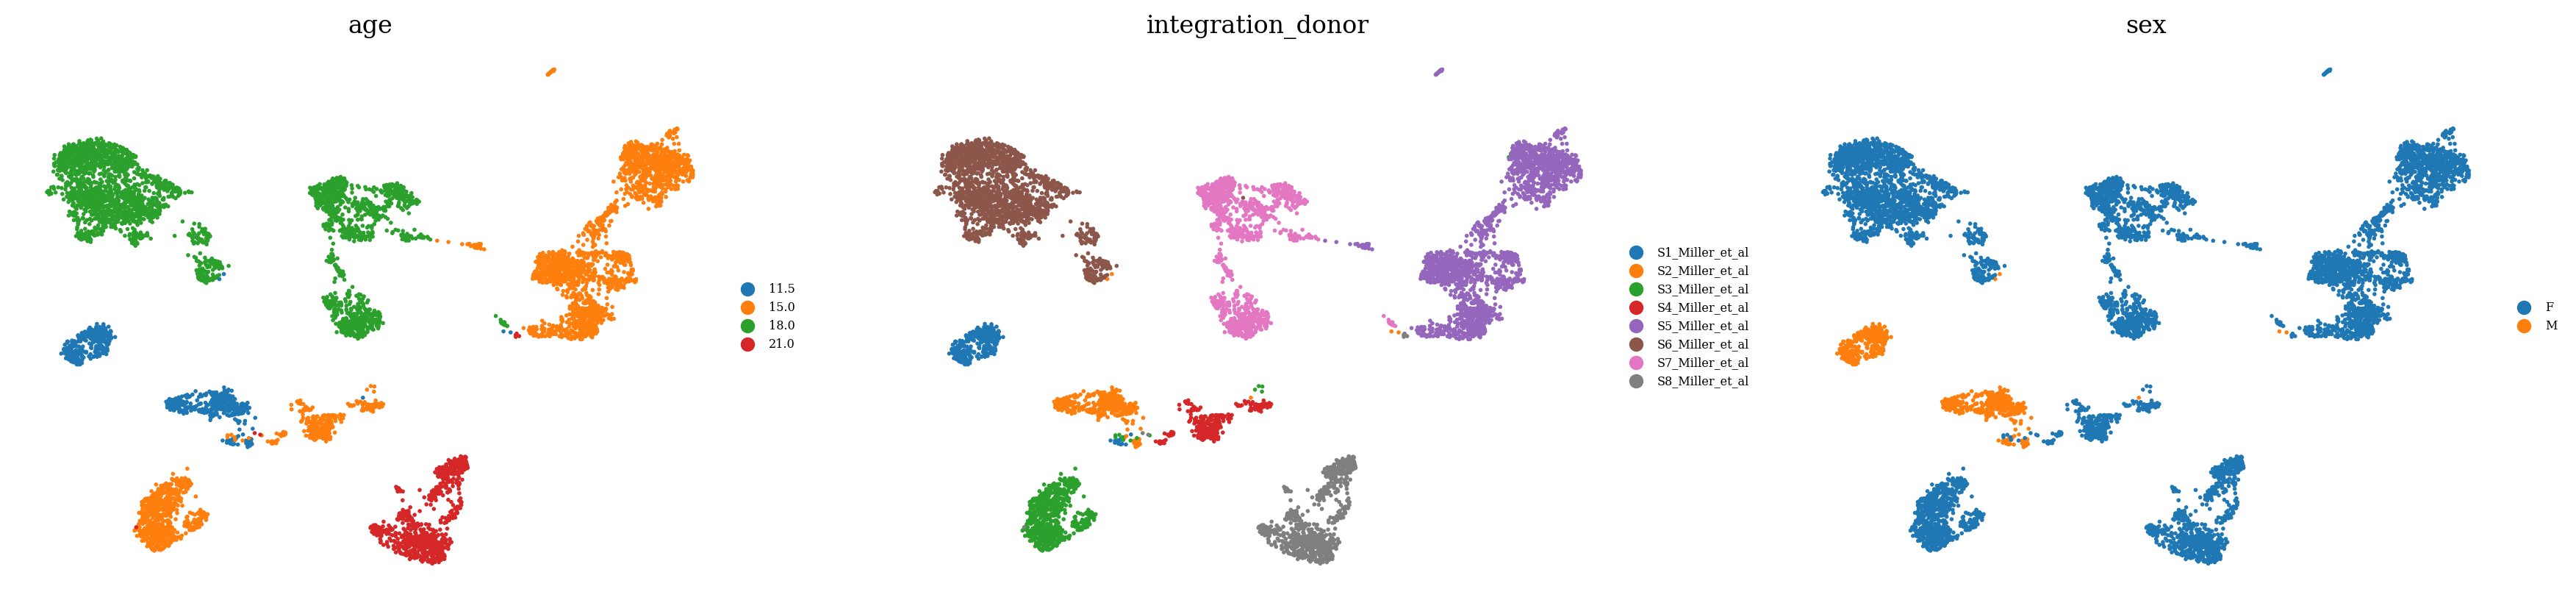

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

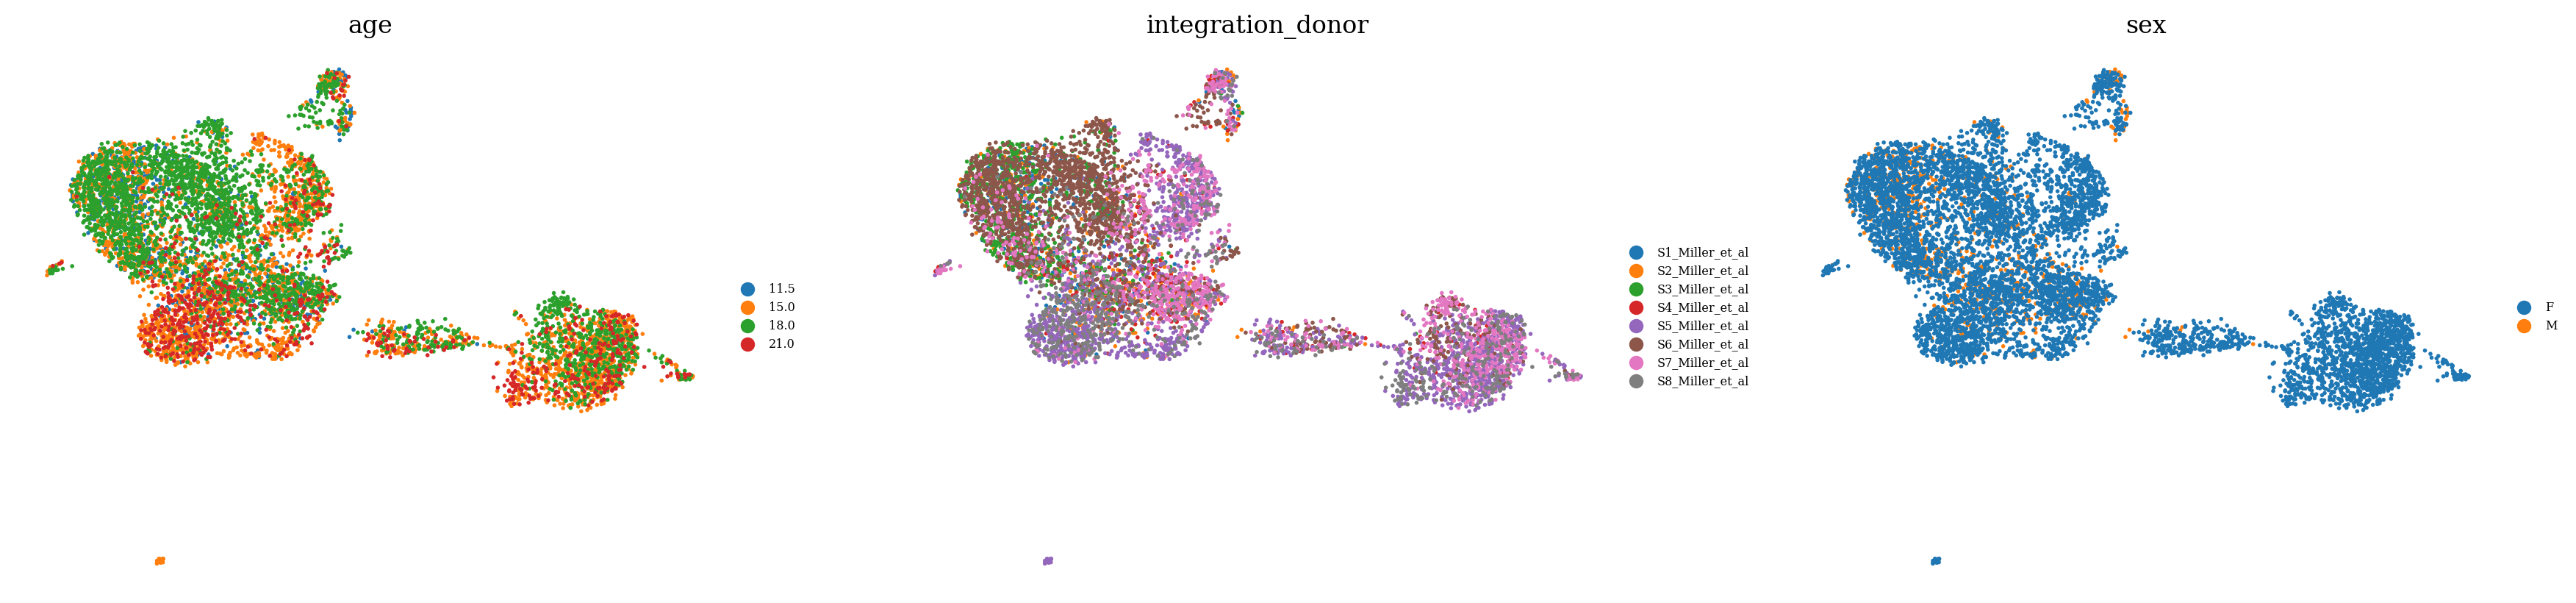

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 1/232 [00:00<00:32,  7.20it/s]

  9%|▊         | 20/232 [00:00<00:02, 97.98it/s]

 17%|█▋        | 39/232 [00:00<00:01, 133.77it/s]

 25%|██▌       | 58/232 [00:00<00:01, 153.87it/s]

 34%|███▎      | 78/232 [00:00<00:00, 167.11it/s]

 42%|████▏     | 98/232 [00:00<00:00, 175.70it/s]

 51%|█████     | 118/232 [00:00<00:00, 181.13it/s]

 59%|█████▉    | 137/232 [00:00<00:00, 183.30it/s]

 67%|██████▋   | 156/232 [00:00<00:00, 184.74it/s]

 75%|███████▌  | 175/232 [00:01<00:00, 185.32it/s]

 84%|████████▎ | 194/232 [00:01<00:00, 185.60it/s]

 92%|█████████▏| 213/232 [00:01<00:00, 185.98it/s]

100%|██████████| 232/232 [00:01<00:00, 181.87it/s]

100%|██████████| 232/232 [00:01<00:00, 168.23it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.7267122892039806

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)